## Bibliotecas

In [2756]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from kmodes.kprototypes import KPrototypes 
from sklearn.preprocessing import scale
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

## Leitura de dataframes

Foram disponibilizados 3 dataframes com informações relacionadas à conta, cliente e transações realizadas

In [2757]:
accounts = pd.read_csv(r'accounts.csv') #dados da conta
person = pd.read_csv(r'person.csv') #dados do cliente
transactions = pd.read_csv(r'transactions.csv') #dados das transações

### df accounts


In [2758]:
accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7569 non-null   object 
 1   type           7569 non-null   object 
 2   subtype        7569 non-null   object 
 3   balance        7569 non-null   float64
 4   currency_code  7569 non-null   object 
 5   name           7569 non-null   object 
 6   person_id      7569 non-null   object 
 7   account_id     7569 non-null   object 
 8   date           7569 non-null   object 
dtypes: float64(1), object(8)
memory usage: 532.3+ KB


In [2759]:
accounts.head(3)

,id,type,subtype,balance,currency_code,name,person_id,account_id,date
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-14 14:03:16
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-15 15:50:21
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,dcd96f70-8b16-42b0-a944-afec5d8305ce,2023-09-09 03:38:49


In [2760]:
accounts['date'] = pd.to_datetime(accounts['date']) #transformando variavel em data

In [2761]:
pd.crosstab(accounts['name'], accounts['subtype']) #constatando que name e subtype são traduções um do outro

subtype,CHECKING_ACCOUNT,CREDIT_CARD,SAVINGS_ACCOUNT
name,,,
Caixinha,0,0,792
Cartão de Crédito,0,2619,0
Conta Corrente,2509,0,0
Conta Remunerada,0,0,804
Poupança,0,0,845


#### Devido a grande quantidade de dados categóricos em nosso df, vamos aplicar o teste de qui_quadrado para examinar as correlações. 

 - Se o p-value for menor que 0.05 então haverá correlação significativa.

In [2762]:
def teste_qui_quadrado(df, coluna1, coluna2):
    #tabela de contingência
    tabela_contingencia = pd.crosstab(df[coluna1], df[coluna2])
    
    #teste qui-quadrado
    chi2, p, _, _ = chi2_contingency(tabela_contingencia)
      
    print(f"Estatística Qui-Quadrado: {chi2}")
    print(f"Valor P: {p}")

    # Se um valor P < 0.05 é considerado significativo
    if p < 0.05:
        print(f"Há uma associação estatisticamente significativa entre as variáveis {coluna1} e {coluna2}.")
    else:
        print("Não há uma associação estatisticamente significativa entre as variáveis.")


In [2763]:
teste_qui_quadrado(accounts, 'name', 'type')
print()
teste_qui_quadrado(accounts, 'type', 'subtype')
print()
teste_qui_quadrado(accounts, 'currency_code', 'type')
print()
teste_qui_quadrado(accounts, 'balance', 'type')

Estatística Qui-Quadrado: 7569.0
Valor P: 0.0
Há uma associação estatisticamente significativa entre as variáveis name e type.

Estatística Qui-Quadrado: 7568.999999999999
Valor P: 0.0
Há uma associação estatisticamente significativa entre as variáveis type e subtype.

Estatística Qui-Quadrado: 0.0
Valor P: 1.0
Não há uma associação estatisticamente significativa entre as variáveis.

Estatística Qui-Quadrado: 7535.85656044986
Valor P: 0.49505009209378353
Não há uma associação estatisticamente significativa entre as variáveis.


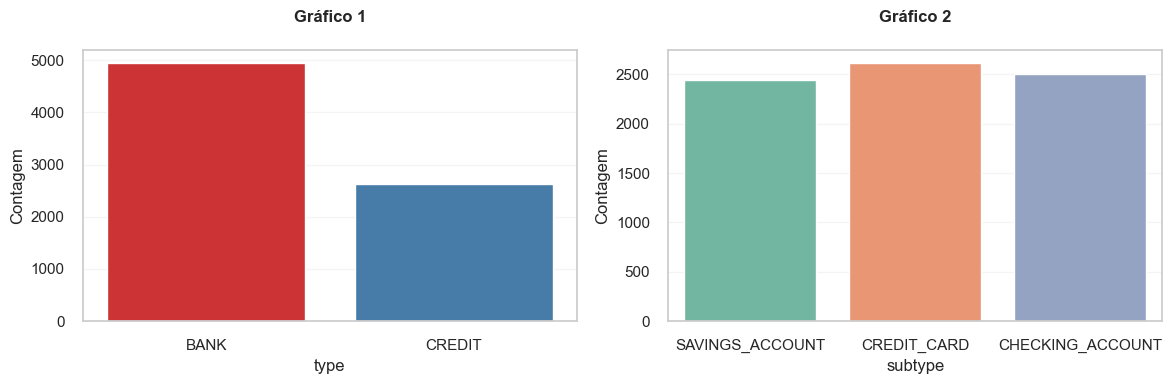

In [2764]:
# Crie uma figura com dois subplots (gráficos lado a lado)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 linha, 2 colunas

# Primeiro countplot
sns.set(style="whitegrid")
sns.countplot(data=accounts, x='type', palette='Set1', ax=axes[0])  # axes[0] representa o primeiro subplot
axes[0].set_xlabel('type')
axes[0].set_ylabel('Contagem')
axes[0].set_title('Gráfico 1')

sns.set(style="whitegrid")
sns.countplot(data=accounts, x='subtype', palette='Set2', ax=axes[1])  # axes[1] representa o segundo subplot
axes[1].set_xlabel('subtype')
axes[1].set_ylabel('Contagem')
axes[1].set_title('Gráfico 2')

# Ajuste o espaço entre os gráficos
plt.tight_layout()

# Exiba a figura com os dois gráficos
plt.show()

Observa-se que as operações realizadas no credito são metade das realizadas em conta, no entanto, vemos no gráfico 2 que existem dois tipos de operações em conta e apenas uma do cartão de crédito, a qual apresenta um alto volume de operações.

In [2765]:
accounts['month'] = accounts['date'].dt.month #criando coluna mensal

In [2766]:
accounts['month'].value_counts()

month
9    7199
8     302
7      58
6      10
Name: count, dtype: int64

A coluna date neste df se refere à data em que as informações foram extraídas.

## df person

In [2767]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531 entries, 0 to 2530
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2531 non-null   object
 1   name         2531 non-null   object
 2   suitability  2084 non-null   object
dtypes: object(3)
memory usage: 59.4+ KB


dado a ser explorado 'suitability'

In [2768]:
person['suitability'].value_counts(True)

suitability
agressivo               0.213052
conservador             0.202495
moderado-agressivo      0.201536
moderado                0.196737
moderado-conservador    0.186180
Name: proportion, dtype: float64

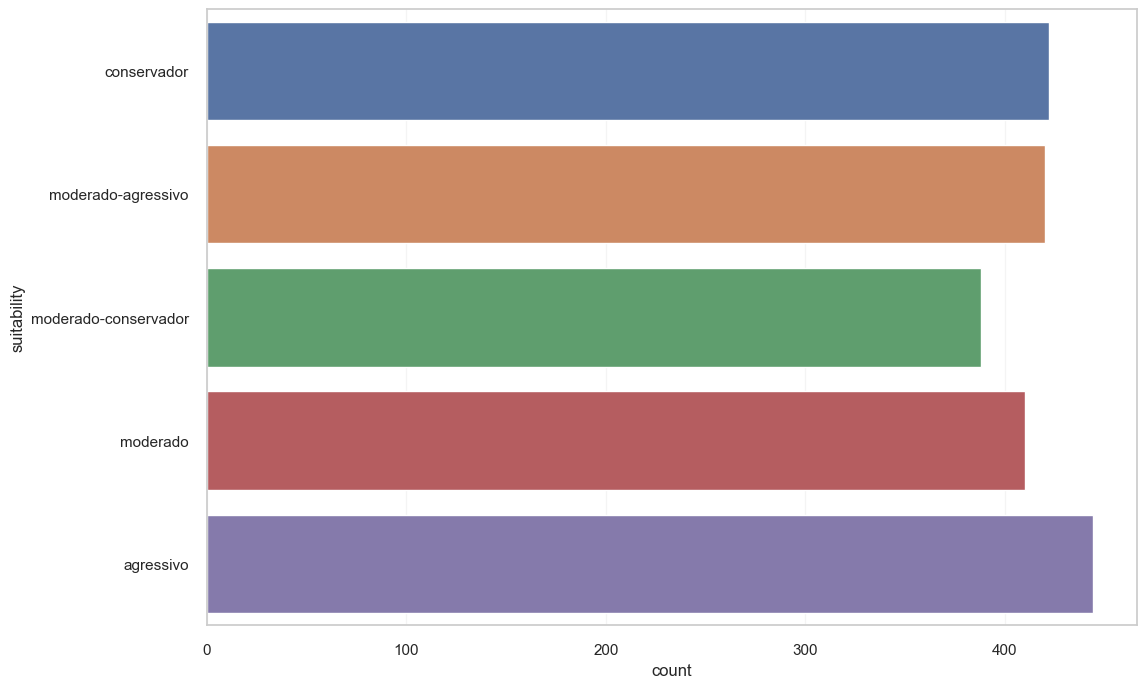

In [2769]:
sns.countplot(data=person, y='suitability')
plt.xticks(rotation=0);

Vamos considerar o suitability como um dado de apoio, pois além dos perfis que teremos agrupados, poderemos comparar com o perfil de investimento gerado para cada cliente.

## df transaction

In [2770]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             400110 non-null  object 
 1   currency_code  400110 non-null  object 
 2   amount         400110 non-null  float64
 3   date           400110 non-null  object 
 4   category       368501 non-null  object 
 5   account_id     400110 non-null  object 
dtypes: float64(1), object(5)
memory usage: 18.3+ MB


In [2771]:
transactions['id'].value_counts()

id
b7ebd81b-98f7-47ab-91f3-52bc80be57a6    1
04c432c0-f944-4446-98cb-7622b506885c    1
d4d4b040-c480-497d-9e69-a706f96e32ba    1
b203ec51-4922-4009-85bd-6177370692ad    1
b465867c-0731-4297-81c6-06965451fe24    1
                                       ..
8fb4221a-3ddd-478d-b016-6751b1cafec7    1
1d705eca-1d00-4805-a799-dc274c4969f1    1
2dedbe0e-745c-48b0-8fbd-e2747fca9d1d    1
c33d8289-3e64-4fdd-8667-f6c4298764d1    1
c2b4de56-d6bc-4b4f-b7c5-4c0aea79a129    1
Name: count, Length: 400110, dtype: int64

In [2772]:
transactions.head()

,id,currency_code,amount,date,category,account_id
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


In [2773]:
(transactions['id'].value_counts() > 1).sum()

0

In [2774]:
transactions['currency_code'].value_counts() #apenas moeda brasileira

currency_code
BRL    400110
Name: count, dtype: int64

In [2775]:
transactions['category'].value_counts(True).reset_index()

,category,proportion
0,Recebido,0.097435
1,Transporte,0.092670
2,Moradia,0.092648
3,"Imposto, juros e multa",0.092190
4,Compras,0.091829
5,Outras saídas,0.091826
6,Alimentação,0.089221
7,Investimento,0.088681
8,Lazer,0.088410
9,Educação,0.087712


In [2776]:
(transactions['amount'] > 0).value_counts() #valores recebidos ou investidos

amount
False    331526
True      68584
Name: count, dtype: int64

In [2777]:
transactions['isin'] = (transactions['amount'] > 0)

In [2778]:
pd.crosstab(transactions['category'], transactions['isin']) #constatando de onde pertencem os dados positivos

isin,False,True
category,,
Alimentação,32878,0
Compras,33839,0
Educação,32322,0
"Imposto, juros e multa",33972,0
Investimento,0,32679
Lazer,32579,0
Moradia,34141,0
Outras saídas,33838,0
Recebido,0,35905


In [2779]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             400110 non-null  object 
 1   currency_code  400110 non-null  object 
 2   amount         400110 non-null  float64
 3   date           400110 non-null  object 
 4   category       368501 non-null  object 
 5   account_id     400110 non-null  object 
 6   isin           400110 non-null  bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 18.7+ MB


In [2780]:
#correlação
teste_qui_quadrado(transactions, 'category', 'currency_code')
print()
teste_qui_quadrado(transactions, 'category', 'amount')
print()
teste_qui_quadrado(transactions, 'category', 'date')
print()
teste_qui_quadrado(transactions, 'category', 'currency_code')
print()

teste_qui_quadrado(transactions, 'amount', 'currency_code')
print()
#teste_qui_quadrado(transactions, 'amount', 'date')
#print()

teste_qui_quadrado(transactions, 'currency_code', 'date')
print()


Estatística Qui-Quadrado: 0.0
Valor P: 1.0
Não há uma associação estatisticamente significativa entre as variáveis.



Estatística Qui-Quadrado: 2267933.941974124
Valor P: 0.0
Há uma associação estatisticamente significativa entre as variáveis category e amount.

Estatística Qui-Quadrado: 3604458.286727047
Valor P: 0.5120404392604657
Não há uma associação estatisticamente significativa entre as variáveis.

Estatística Qui-Quadrado: 0.0
Valor P: 1.0
Não há uma associação estatisticamente significativa entre as variáveis.

Estatística Qui-Quadrado: 0.0
Valor P: 1.0
Não há uma associação estatisticamente significativa entre as variáveis.

Estatística Qui-Quadrado: 0.0
Valor P: 1.0
Não há uma associação estatisticamente significativa entre as variáveis.



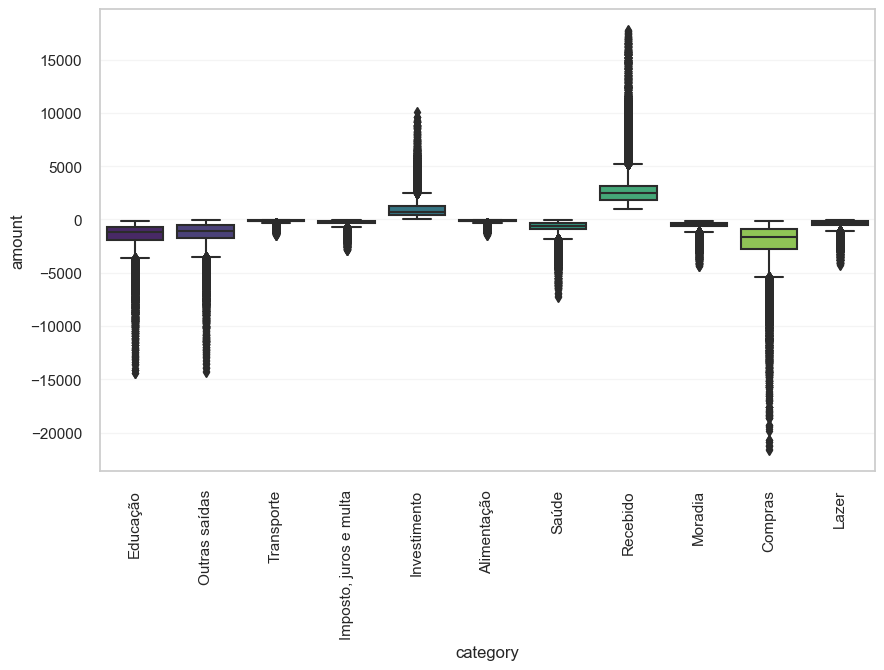

In [2781]:
#observando relações dos gastos por categoria
plt.figure(figsize=(10,6))
#inserindo os boxplots
sns.boxplot(data=transactions, x='category', y='amount', palette='viridis');
plt.xticks(rotation=90);

Por mais que existam alguns gastos bem altos, os dados fazem sentido e não irei tratar possíveis outliers, pois pra mim não estão presentes.

In [2782]:
transactions.groupby('category')['amount'].sum()

category
Alimentação              -4.918631e+06
Compras                  -7.466296e+07
Educação                 -5.143856e+07
Imposto, juros e multa   -9.779061e+06
Investimento              3.183804e+07
Lazer                    -1.395145e+07
Moradia                  -1.875807e+07
Outras saídas            -4.630159e+07
Recebido                  1.085280e+08
Saúde                    -2.424834e+07
Transporte               -5.159700e+06
Name: amount, dtype: float64

In [2783]:
transactions.head()

,id,currency_code,amount,date,category,account_id,isin
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,False
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,False
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,False


In [2784]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             400110 non-null  object 
 1   currency_code  400110 non-null  object 
 2   amount         400110 non-null  float64
 3   date           400110 non-null  object 
 4   category       368501 non-null  object 
 5   account_id     400110 non-null  object 
 6   isin           400110 non-null  bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 18.7+ MB


In [2785]:
transactions['date'] = pd.to_datetime(transactions['date']) #transformando coluna em datetime
transactions['date'].dt.date

0         2023-07-20
1         2023-07-23
2         2023-06-26
3         2023-06-21
4         2023-08-05
             ...    
400105    2022-12-02
400106    2023-07-22
400107    2023-07-24
400108    2023-06-25
400109    2023-06-17
Name: date, Length: 400110, dtype: object

In [2786]:
transactions['only_date'] = transactions['date'].dt.date #separando data da hora
transactions.head()

,id,currency_code,amount,date,category,account_id,isin,only_date
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-20
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-23
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-26
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-21
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-08-05


In [2787]:
saldo_cliente = transactions.groupby('id').amount.sum().reset_index()
saldo_cliente[saldo_cliente['amount'] > 0].reset_index()

,index,id,amount
0,4,0001c0f4-c274-4325-a55c-c63b732cde58,9869.21
1,6,0001e28b-6cdd-41e9-9ba6-41f60cac1a11,91.39
2,8,00029ccb-f109-4736-822c-d0f97dee0be4,592.28
3,18,0003a285-f03f-425d-a337-8dfcf6c956ce,2879.77
4,19,0003a5d8-cd74-4bbe-8667-f79f3649b297,2761.80
...,...,...,...
68579,400062,fff7621e-cee9-4d82-aa67-d8bdee1d5f38,1463.45
68580,400063,fff7aa97-27a1-4d7f-8ad3-dcc6b1ed7bfb,2750.11
68581,400082,fffb5394-0a8e-4c83-bd50-d12cad5d7f17,646.55
68582,400104,fffee094-ef6a-486c-a9b0-b6329be94a94,2216.19


In [2788]:
date_graf = transactions['only_date'].value_counts().reset_index()
date_graf.head(10)

,only_date,count
0,2023-06-30,4559
1,2023-07-09,4546
2,2023-06-29,4544
3,2023-06-28,4537
4,2023-07-07,4518
5,2023-07-23,4506
6,2023-06-27,4506
7,2023-06-22,4501
8,2023-07-04,4499
9,2023-07-28,4492


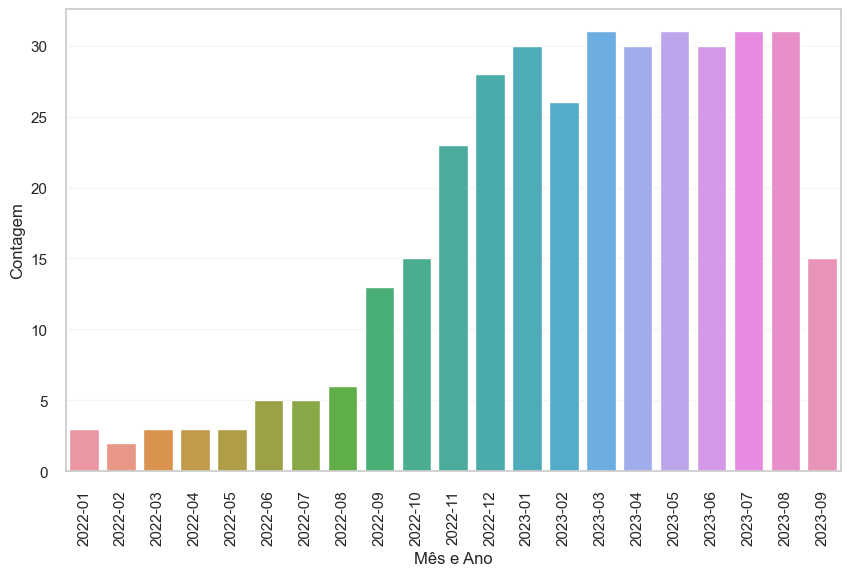

In [2789]:
# coluna 'only_date' para datetime, se ainda não estiver
date_graf['only_date'] = pd.to_datetime(date_graf['only_date'])

#  mês e o ano da coluna 'only_date' em um novo DataFrame
date_graf['year_month'] = date_graf['only_date'].dt.to_period('M')

# DataFrame com base na coluna 'year_month'
date_graf = date_graf.sort_values(by='year_month')

#  tamanho da figura
plt.figure(figsize=(10, 6))

# gráfico de contagem com base no mês e ano
sns.countplot(x=date_graf['year_month'])
plt.xticks(rotation=90)

# Adicione rótulos apropriados aos eixos
plt.xlabel('Mês e Ano')
plt.ylabel('Contagem')

# Exiba o gráfico
plt.show()

Aqui podemos observar um crescimento no número de operações a partir do final de 2022

## Unindo dfs

In [2790]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             400110 non-null  object        
 1   currency_code  400110 non-null  object        
 2   amount         400110 non-null  float64       
 3   date           400110 non-null  datetime64[ns]
 4   category       368501 non-null  object        
 5   account_id     400110 non-null  object        
 6   isin           400110 non-null  bool          
 7   only_date      400110 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(5)
memory usage: 21.7+ MB


In [2791]:
accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             7569 non-null   object        
 1   type           7569 non-null   object        
 2   subtype        7569 non-null   object        
 3   balance        7569 non-null   float64       
 4   currency_code  7569 non-null   object        
 5   name           7569 non-null   object        
 6   person_id      7569 non-null   object        
 7   account_id     7569 non-null   object        
 8   date           7569 non-null   datetime64[ns]
 9   month          7569 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(7)
memory usage: 561.9+ KB


In [2792]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531 entries, 0 to 2530
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2531 non-null   object
 1   name         2531 non-null   object
 2   suitability  2084 non-null   object
dtypes: object(3)
memory usage: 59.4+ KB


In [2793]:
merge = pd.merge(transactions, accounts, how = 'left', on = 'account_id')
merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_x             400110 non-null  object        
 1   currency_code_x  400110 non-null  object        
 2   amount           400110 non-null  float64       
 3   date_x           400110 non-null  datetime64[ns]
 4   category         368501 non-null  object        
 5   account_id       400110 non-null  object        
 6   isin             400110 non-null  bool          
 7   only_date        400110 non-null  object        
 8   id_y             400110 non-null  object        
 9   type             400110 non-null  object        
 10  subtype          400110 non-null  object        
 11  balance          400110 non-null  float64       
 12  currency_code_y  400110 non-null  object        
 13  name             400110 non-null  object        
 14  person_id        400

In [2794]:
df = pd.merge(merge, person, how='inner', left_on='person_id', right_on='id')


In [2795]:
df = df.dropna() #excluindo nulos

In [2796]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304238 entries, 0 to 400109
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id_x             304238 non-null  object        
 1   currency_code_x  304238 non-null  object        
 2   amount           304238 non-null  float64       
 3   date_x           304238 non-null  datetime64[ns]
 4   category         304238 non-null  object        
 5   account_id       304238 non-null  object        
 6   isin             304238 non-null  bool          
 7   only_date        304238 non-null  object        
 8   id_y             304238 non-null  object        
 9   type             304238 non-null  object        
 10  subtype          304238 non-null  object        
 11  balance          304238 non-null  float64       
 12  currency_code_y  304238 non-null  object        
 13  name_x           304238 non-null  object        
 14  person_id        304238 n

In [2797]:
df = df.rename(columns={'id_x':'id', 'currency_code_x':'currency_code','date_x': 'date','name_x':'name','id':'person'}) #renomeando colunas

In [2798]:
df.drop(columns = ['id_y','currency_code_y','date_y','name_y', 'person'], inplace=True) #excluindo colunas inuteis

In [2799]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304238 entries, 0 to 400109
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             304238 non-null  object        
 1   currency_code  304238 non-null  object        
 2   amount         304238 non-null  float64       
 3   date           304238 non-null  datetime64[ns]
 4   category       304238 non-null  object        
 5   account_id     304238 non-null  object        
 6   isin           304238 non-null  bool          
 7   only_date      304238 non-null  object        
 8   type           304238 non-null  object        
 9   subtype        304238 non-null  object        
 10  balance        304238 non-null  float64       
 11  name           304238 non-null  object        
 12  person_id      304238 non-null  object        
 13  month          304238 non-null  int32         
 14  suitability    304238 non-null  object        
dtypes: bo

In [2800]:
df['person_id'].value_counts()

person_id
20bae25c-3759-4cec-a87c-83733c83e74b    421
9645f984-0a5a-48ce-9b5a-90dd546920b4    414
3e6582a0-723a-4d35-9a2f-d2c6e0938b31    406
240d9250-bc24-488a-a85a-ed33257d4304    403
00b033a5-2d25-47ae-8a6b-5416c39c3c89    399
                                       ... 
17b928be-04f0-4ab9-8ef2-3ee327d8e8fb      2
80a22f4d-af81-4f65-8c97-e3e1cf62669a      1
3de59930-8697-467f-a584-92f4dc5bf4af      1
f92681d1-6e02-4224-ba54-420f4dfea985      1
26274a9e-5974-4c39-aa59-ca04b4416d5e      1
Name: count, Length: 2084, dtype: int64

In [2801]:
#formatando datetime

df['date'] = pd.to_datetime(df['date'])
df['only_date'] = pd.to_datetime(df['only_date'])

In [2802]:
#criando coluna de dia da semana
df['dia_semana'] = df['date'].dt.day_name() 

In [2803]:
df.head(3)

,id,currency_code,amount,date,category,account_id,isin,only_date,type,subtype,balance,name,person_id,month,suitability,dia_semana
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-20,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Thursday
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-23,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Sunday
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-26,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Monday


In [2804]:
df.describe()

,amount,date,only_date,balance,month
count,304238.000000,304238,304238,304238.000000,304238.000000
mean,-294.478800,2023-07-30 01:45:05.959436544,2023-07-29 13:46:51.885432064,5698.796057,8.993761
min,-21647.510000,2022-01-03 01:46:38,2022-01-03 00:00:00,12.410000,6.000000
25%,-802.247500,2023-07-07 19:23:15,2023-07-07 00:00:00,2535.670000,9.000000
50%,-281.420000,2023-07-30 14:29:35.500000,2023-07-30 00:00:00,5084.870000,9.000000
75%,-65.480000,2023-08-22 21:38:05.249999872,2023-08-22 00:00:00,7600.120000,9.000000
max,17764.300000,2023-09-15 16:27:41,2023-09-15 00:00:00,44240.160000,9.000000
std,1802.702128,NaN,NaN,4714.687439,0.083637


In [2805]:
df['suitability'].value_counts()

suitability
agressivo               64105
conservador             62087
moderado-agressivo      61289
moderado                60578
moderado-conservador    56179
Name: count, dtype: int64

In [2806]:
df['category'].value_counts()

category
Recebido                  29707
Transporte                28222
Moradia                   28202
Imposto, juros e multa    28110
Compras                   27881
Outras saídas             27869
Alimentação               27136
Investimento              26918
Lazer                     26862
Educação                  26738
Saúde                     26593
Name: count, dtype: int64

Correlações

In [2807]:
teste_qui_quadrado(df, 'suitability', 'amount')
print()
teste_qui_quadrado(df, 'category', 'amount')
print()
teste_qui_quadrado(df, 'suitability', 'category')
print()

Estatística Qui-Quadrado: 721548.9910650532
Valor P: 0.0
Há uma associação estatisticamente significativa entre as variáveis suitability e amount.

Estatística Qui-Quadrado: 1965580.9294158225
Valor P: 0.0
Há uma associação estatisticamente significativa entre as variáveis category e amount.

Estatística Qui-Quadrado: 42.64806871250919
Valor P: 0.35793145663631515
Não há uma associação estatisticamente significativa entre as variáveis.



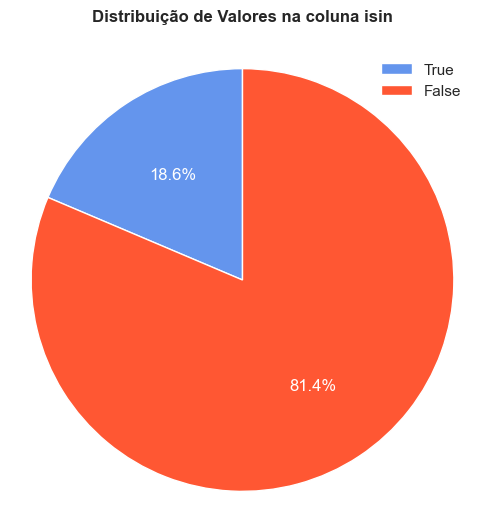

In [2808]:
quantidade_true = (df['isin'] == True).sum()
quantidade_false = (df['isin'] == False).sum()

# Crie o gráfico de pizza
plt.figure(figsize=(6, 6))  # Define o tamanho da figura (opcional)
plt.pie([quantidade_true, quantidade_false], labels=['True', 'False'], colors=['#6495ED','#FF5733'], autopct='%1.1f%%', startangle=90, textprops={'color': 'white'})
plt.title('Distribuição de Valores na coluna isin')  # Título do gráfico

plt.legend(['True', 'False'], loc='upper right')
# Mostre o gráfico
plt.axis('equal')  
plt.show()

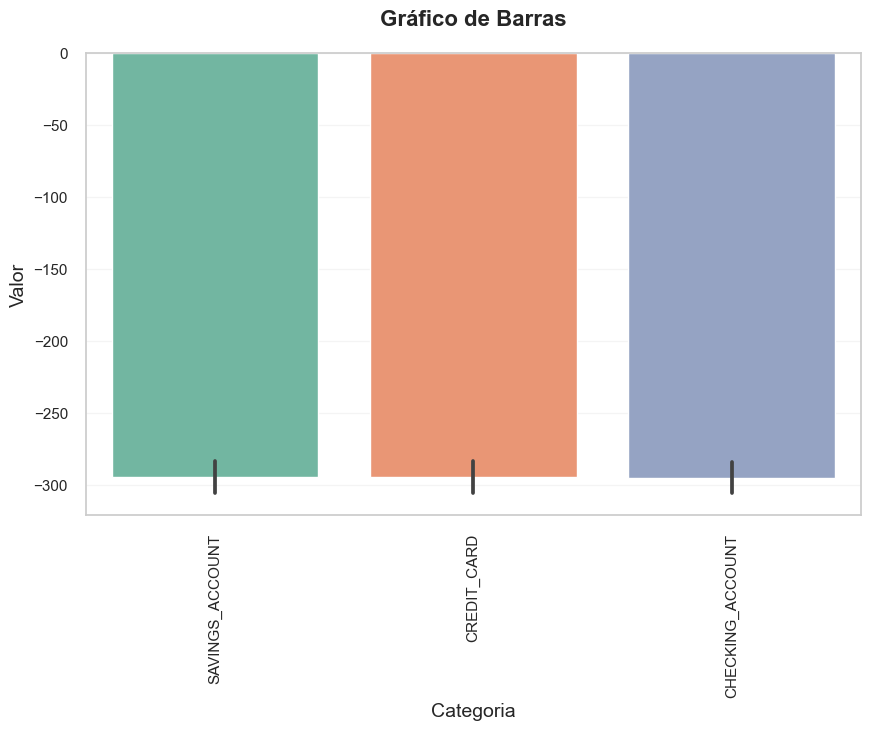

In [2809]:
# Defina o estilo de plotagem do Seaborn (opcional)
sns.set(style="whitegrid")

# Crie um gráfico de barras
plt.figure(figsize=(10, 6))  # Defina o tamanho da figura (opcional)

# Use o método barplot do Seaborn para criar o gráfico de barras
ax = sns.barplot(x='subtype', y='amount', data=df, palette="Set2")

# Personalize o gráfico
ax.set_title('Gráfico de Barras', fontsize=16)  # Título do gráfico
ax.set_xlabel('Categoria', fontsize=14)  # Rótulo do eixo x
ax.set_ylabel('Valor', fontsize=14)  # Rótulo do eixo y

# Adicione rótulos aos topos das barras
#for p in ax.patches:
#    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
 #               textcoords='offset points', rotation=90)

plt.xticks(rotation=90) 
# Mostre o gráfico
plt.show()

In [2810]:
df['subtype'].value_counts()

subtype
CREDIT_CARD         105200
CHECKING_ACCOUNT    100655
SAVINGS_ACCOUNT      98383
Name: count, dtype: int64

In [2811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304238 entries, 0 to 400109
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             304238 non-null  object        
 1   currency_code  304238 non-null  object        
 2   amount         304238 non-null  float64       
 3   date           304238 non-null  datetime64[ns]
 4   category       304238 non-null  object        
 5   account_id     304238 non-null  object        
 6   isin           304238 non-null  bool          
 7   only_date      304238 non-null  datetime64[ns]
 8   type           304238 non-null  object        
 9   subtype        304238 non-null  object        
 10  balance        304238 non-null  float64       
 11  name           304238 non-null  object        
 12  person_id      304238 non-null  object        
 13  month          304238 non-null  int32         
 14  suitability    304238 non-null  object        
 15  dia_s

In [2812]:
df.sample(5)

,id,currency_code,amount,date,category,account_id,isin,only_date,type,subtype,balance,name,person_id,month,suitability,dia_semana
114048,6330571f-99b5-41f3-802e-ff23a1b1d7a6,BRL,-304.10,2023-07-04 13:17:27,Saúde,f101cf26-f9cb-45b3-9037-1d8fd69e9da2,False,2023-07-04,BANK,SAVINGS_ACCOUNT,6759.38,Caixinha,0926fc4d-61c3-4584-8ed9-84ab4b30ed12,9,moderado,Tuesday
241582,cfb1ef33-aff2-41cd-81e2-cae72f15a91c,BRL,-393.80,2023-09-03 07:19:17,Lazer,c9075155-baf6-4b9f-98c3-4a4c6747943f,False,2023-09-03,CREDIT,CREDIT_CARD,8538.95,Cartão de Crédito,b6d66b1e-c360-4176-8019-8b0c5669bc8c,9,moderado,Sunday
117669,7f710f01-da10-4d09-b310-a5edaceaf385,BRL,1684.12,2023-06-22 10:23:54,Recebido,1133566d-de5c-4d45-a4db-f0df5724bdbe,True,2023-06-22,BANK,CHECKING_ACCOUNT,8713.39,Conta Corrente,3d934eab-4ce2-4713-9755-8eac26c647dc,9,agressivo,Thursday
382614,f2913a1f-8e1e-4c03-bea1-989ffa483ce8,BRL,-107.31,2023-09-09 11:49:18,"Imposto, juros e multa",70ad35a9-848f-4ea9-bb4d-585de14801f3,False,2023-09-09,BANK,CHECKING_ACCOUNT,4589.60,Conta Corrente,f8a81789-de87-47ce-8853-277eab329f17,9,moderado-agressivo,Saturday
272854,07ab5704-49b0-4439-9261-9a2078916b1b,BRL,-43.19,2023-09-03 10:43:54,"Imposto, juros e multa",6ff38440-32b8-44d1-b57d-055bab656ea2,False,2023-09-03,BANK,CHECKING_ACCOUNT,8047.40,Conta Corrente,bf55ec8c-ec8e-4a9f-a796-0437a5685a48,9,moderado-agressivo,Sunday


## Feature Engineering

#### Features criadas
- catory_max: categoria em que o cliente mais gastou
- 'total_spent': valor gasto na categoria
- percentis (25, 50 e 75) por categoria: calculo dos percentis por categoria
- total_{categoria}: valor total gasto em cada categoria

#### Retirado do df
- A feature 'balance' foi desconsiderada por se tratar de uma informação inválida gerada durante a junção de df's
- O suitability será considerado uma metrica de avaliação do modelo e por isso será retirado do dataset
- currency_code é o mesmo para todos os clientes, então não gerará nenhum insight


Tenha em mente que o suitability será uma das variáveis de avaliação e estamos levando em conta que a mesma e definida por:

    - nivel de conhecimento sobre investimento
    - formação  ou experiencia profissional correlacionada
    - renda mensal
    - 6x o valor para cobrir imprevistos?
    - frequencia de investimento
    - quanto investido em ações
    - grau de risco do investimento
    - periodo para uso do investimento

In [2813]:
df.head()

,id,currency_code,amount,date,category,account_id,isin,only_date,type,subtype,balance,name,person_id,month,suitability,dia_semana
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-20,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Thursday
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-23,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Sunday
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-26,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Monday
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-21,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Wednesday
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-08-05,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,9,conservador,Saturday


- Vamos desconsiderar a coluna 'balance' pois ela é referente a um único registro derivado do df 'accounts', proveniente do saldo da conta no momento em que a informação foi extraída.
- O currency_code é o mesmo para todos os clientes, então também não faz sentido ser utilizado por agora.

In [2814]:
df.drop(columns=['balance','currency_code','month'], inplace=True)

- Serão criadas features em cima de cada categoria, explorando as métricas de quantidade, total, media 25, 50 e 75.
- Features: categoria em que o cliente mais gastou, mês em que o cliente mais gastou, média de gastos por mês
- Total investido por cliente

In [2815]:
df.groupby(['person_id', 'category'])['amount'].sum().reset_index()


,person_id,category,amount
0,000be23a-894b-4eca-aa31-5373556f8204,Alimentação,-2605.89
1,000be23a-894b-4eca-aa31-5373556f8204,Compras,-84880.85
2,000be23a-894b-4eca-aa31-5373556f8204,Educação,-25568.23
3,000be23a-894b-4eca-aa31-5373556f8204,"Imposto, juros e multa",-7735.55
4,000be23a-894b-4eca-aa31-5373556f8204,Investimento,22667.60
...,...,...,...
22368,ffe36cb3-c406-46dd-931e-0b38143a1b7c,Moradia,-5526.80
22369,ffe36cb3-c406-46dd-931e-0b38143a1b7c,Outras saídas,-25451.26
22370,ffe36cb3-c406-46dd-931e-0b38143a1b7c,Recebido,40585.20
22371,ffe36cb3-c406-46dd-931e-0b38143a1b7c,Saúde,-7069.79


In [2816]:
df['category'].value_counts()

category
Recebido                  29707
Transporte                28222
Moradia                   28202
Imposto, juros e multa    28110
Compras                   27881
Outras saídas             27869
Alimentação               27136
Investimento              26918
Lazer                     26862
Educação                  26738
Saúde                     26593
Name: count, dtype: int64

In [2817]:
#Selecionando o maior gasto na categoria
    
customer_least_spent = df.groupby(['person_id', 'category'])['amount'].sum().reset_index()
idx = customer_least_spent.groupby('person_id')['amount'].idxmin() #foi usado o idxmin() pois as saidas da conta estão expressas em valores negativos
features_clientes = customer_least_spent.loc[idx][['person_id', 'category']]


In [2818]:
# Agrupar por cliente e categoria e calcular o valor total gasto em cada categoria
customer_category_total = df.groupby(['person_id', 'category'])['amount'].sum().reset_index()

# Combinar os DataFrames para obter o valor total gasto nas categorias em que cada cliente gastou mais
features_clientes = pd.merge(features_clientes, customer_category_total, on=['person_id', 'category'], how='left')
features_clientes.rename(columns={'category':'category_max','amount': 'total_spent'}, inplace=True)

features_clientes.head()


,person_id,category_max,total_spent
0,000be23a-894b-4eca-aa31-5373556f8204,Compras,-84880.85
1,001de888-9b29-4b8e-95ca-59adc5903f45,Compras,-38596.47
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,Compras,-173636.11
3,007acb4a-2a68-4437-85e2-0bbda827360c,Compras,-11233.45
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,Educação,-4747.80


In [2819]:
unique_categories = df['category'].unique()

In [2820]:
for category in unique_categories:
    #categoria atual
    category_df = df[df['category'] == category]
    
    #Agrupar por cliente e calcular o total gasto nessa categoria
    category_total = category_df.groupby('person_id')['amount'].sum().reset_index()
    
    #Renomear a coluna 'amount' para o nome da categoria
    category_total = category_total.rename(columns={'amount': f'total_{category}'})
    
    #Agrupando por cliente e calculando os percentis
    category_percentiles = category_df.groupby('person_id')['amount'].quantile([0.25, 0.50, 0.75]).unstack().reset_index()
    
    #Renomear as colunas dos percentis com o sufixo
    category_percentiles.columns = ['person_id', f'25_{category}', f'50_{category}', f'75_{category}']
    
    #Mesclando as informações de total e percentis em um único DataFrame
    merged_category_data = pd.merge(category_total, category_percentiles, on='person_id', how='left')
    
    #Adicionar os resultados ao DataFrame de features
    if features_clientes.empty:
        features_clientes = merged_category_data
    else:
        features_clientes = pd.merge(features_clientes, merged_category_data, on='person_id', how='inner')

#valores ausentes com zero
features_clientes = features_clientes.fillna(0)


In [2821]:
features_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   person_id                     1889 non-null   object 
 1   category_max                  1889 non-null   object 
 2   total_spent                   1889 non-null   float64
 3   total_Educação                1889 non-null   float64
 4   25_Educação                   1889 non-null   float64
 5   50_Educação                   1889 non-null   float64
 6   75_Educação                   1889 non-null   float64
 7   total_Outras saídas           1889 non-null   float64
 8   25_Outras saídas              1889 non-null   float64
 9   50_Outras saídas              1889 non-null   float64
 10  75_Outras saídas              1889 non-null   float64
 11  total_Transporte              1889 non-null   float64
 12  25_Transporte                 1889 non-null   float64
 13  50_

In [2822]:
features_clientes.head()

,person_id,category_max,total_spent,total_Educação,25_Educação,50_Educação,75_Educação,total_Outras saídas,25_Outras saídas,50_Outras saídas,...,50_Moradia,75_Moradia,total_Compras,25_Compras,50_Compras,75_Compras,total_Lazer,25_Lazer,50_Lazer,75_Lazer
0,000be23a-894b-4eca-aa31-5373556f8204,Compras,-84880.85,-25568.23,-2008.620,-1837.390,-1163.8800,-26194.79,-3174.8475,-1250.030,...,-619.950,-518.520,-84880.85,-5248.6275,-3585.35,-2183.7725,-10601.94,-890.210,-582.990,-267.130
1,001de888-9b29-4b8e-95ca-59adc5903f45,Compras,-38596.47,-21176.45,-1604.365,-1038.085,-501.3075,-21929.10,-1442.7400,-1018.415,...,-499.420,-333.850,-38596.47,-2270.8000,-1758.72,-1334.2900,-2949.96,-417.375,-292.070,-113.935
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,Compras,-173636.11,-87152.15,-9348.800,-5944.970,-4376.6900,-38379.81,-7518.9450,-4511.370,...,-2290.110,-2069.605,-173636.11,-14348.5800,-13823.96,-7567.5050,-11516.64,-2273.910,-1909.735,-1545.470
3,007acb4a-2a68-4437-85e2-0bbda827360c,Compras,-11233.45,-3930.56,-1627.190,-914.400,-795.2900,-4699.14,-712.2500,-513.120,...,-385.720,-304.565,-11233.45,-2001.9600,-1319.69,-1020.6150,-1434.24,-282.640,-253.970,-214.550
4,0098357f-73ce-4d05-ba22-ff5a395676ed,Compras,-24230.30,-10493.22,-1646.185,-1386.190,-1026.1450,-17489.81,-2237.1775,-2071.395,...,-649.705,-520.140,-24230.30,-3713.9500,-1959.50,-1798.7600,-2668.12,-1155.175,-997.380,-677.575


In [2823]:
features_clientes.columns

Index(['person_id', 'category_max', 'total_spent', 'total_Educação',
       '25_Educação', '50_Educação', '75_Educação', 'total_Outras saídas',
       '25_Outras saídas', '50_Outras saídas', '75_Outras saídas',
       'total_Transporte', '25_Transporte', '50_Transporte', '75_Transporte',
       'total_Imposto, juros e multa', '25_Imposto, juros e multa',
       '50_Imposto, juros e multa', '75_Imposto, juros e multa',
       'total_Investimento', '25_Investimento', '50_Investimento',
       '75_Investimento', 'total_Alimentação', '25_Alimentação',
       '50_Alimentação', '75_Alimentação', 'total_Saúde', '25_Saúde',
       '50_Saúde', '75_Saúde', 'total_Recebido', '25_Recebido', '50_Recebido',
       '75_Recebido', 'total_Moradia', '25_Moradia', '50_Moradia',
       '75_Moradia', 'total_Compras', '25_Compras', '50_Compras', '75_Compras',
       'total_Lazer', '25_Lazer', '50_Lazer', '75_Lazer'],
      dtype='object')

In [2824]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304238 entries, 0 to 400109
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           304238 non-null  object        
 1   amount       304238 non-null  float64       
 2   date         304238 non-null  datetime64[ns]
 3   category     304238 non-null  object        
 4   account_id   304238 non-null  object        
 5   isin         304238 non-null  bool          
 6   only_date    304238 non-null  datetime64[ns]
 7   type         304238 non-null  object        
 8   subtype      304238 non-null  object        
 9   name         304238 non-null  object        
 10  person_id    304238 non-null  object        
 11  suitability  304238 non-null  object        
 12  dia_semana   304238 non-null  object        
dtypes: bool(1), datetime64[ns](2), float64(1), object(9)
memory usage: 30.5+ MB


### Agora precisamos estabalecer o que são gastos recorrentes (fixos) e o que são gastos variáveis

Para isso, vamos testar uma lógica em uma amostra e caso dê certo passaremos para o df completo

In [2825]:
df['month_year'] = df['date'].dt.strftime('%Y-%m') # criaando coluna para mês e ano (possivel filtro)

### Testando o fluxo

In [2826]:
#df simplificado com amostra de uma conta
df_simplified = df[df['account_id'] == '1968bd13-dd25-4f88-bccc-5cff92d6811b'].sort_values('amount', ascending = True)[['account_id', 'date', 'category', 'amount']]
df_simplified['year_month'] = 100*df_simplified['date'].dt.year + df_simplified['date'].dt.month

df_simplified.head()

,account_id,date,category,amount,year_month
36,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-12 09:08:08,Educação,-2168.97,202309
9,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-02 17:14:39,Educação,-1553.85,202307
31,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-01 11:43:40,Compras,-1387.17,202309
26,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-06 23:31:16,Educação,-987.48,202308
28,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-04 12:12:08,Saúde,-953.38,202307


In [2827]:
df_simplified.date.min(), df_simplified.date.max() #periodo

(Timestamp('2023-05-20 09:09:31'), Timestamp('2023-09-14 14:03:16'))

In [2828]:
#agrupando por e criando coluna para comparação
df_group = df_simplified.groupby(['account_id', 'category', 'year_month']).agg({'amount': list}).reset_index()
df_group['year_month'] = df_group['year_month'] + 1

In [2829]:
#criando um df para realizar a comparação entre as colunas
df_comparison = df_simplified.merge(
    df_group, 
    how = 'left', 
    on = ['account_id', 'category', 'year_month'], 
    suffixes = ('', '_last_month')
)


df_comparison['amount_last_month'] = df_comparison['amount_last_month'].apply(lambda x: x if isinstance(x, list) else [])

In [2830]:
df_comparison.head()

,account_id,date,category,amount,year_month,amount_last_month
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-12 09:08:08,Educação,-2168.97,202309,"[-987.48, -910.26, -580.92]"
1,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-02 17:14:39,Educação,-1553.85,202307,[-329.95]
2,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-01 11:43:40,Compras,-1387.17,202309,[]
3,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-06 23:31:16,Educação,-987.48,202308,"[-1553.85, -618.31, -498.71]"
4,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-04 12:12:08,Saúde,-953.38,202307,[]


In [2831]:
threshold = 0.1 #definindo criterio

#aplicando comparação entre o modulo iterado e o valor
df_comparison['amount_compared'] = df_comparison.apply(lambda x: [round((i/x.amount) - 1, 2) for i in x.amount_last_month], axis = 1)
df_comparison['fixed_expense'] = df_comparison['amount_compared'].apply(lambda x: sum([abs(i) <= threshold for i in x])) * df_comparison['amount']
df_comparison['variable_expense'] = df_comparison['amount_compared'].apply(lambda x: not(sum([abs(i) <= threshold for i in x]))) * df_comparison['amount']

In [2832]:
df_comparison.sort_values(['category', 'date']) 

,account_id,date,category,amount,year_month,amount_last_month,amount_compared,fixed_expense,variable_expense
34,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-08 04:18:04,Alimentação,-33.80,202308,[],[],-0.00,-33.80
33,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-13 22:24:41,Alimentação,-67.58,202309,[-33.8],[-0.5],-0.00,-67.58
2,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-01 11:43:40,Compras,-1387.17,202309,[],[],-0.00,-1387.17
19,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21 20:42:11,Educação,-329.95,202306,[],[],-0.00,-329.95
1,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-02 17:14:39,Educação,-1553.85,202307,[-329.95],[-0.79],-0.00,-1553.85
10,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-15 06:51:56,Educação,-618.31,202307,[-329.95],[-0.47],-0.00,-618.31
13,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20 03:57:57,Educação,-498.71,202307,[-329.95],[-0.34],-0.00,-498.71
3,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-06 23:31:16,Educação,-987.48,202308,"[-1553.85, -618.31, -498.71]","[0.57, -0.37, -0.49]",-0.00,-987.48
5,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-08 06:21:13,Educação,-910.26,202308,"[-1553.85, -618.31, -498.71]","[0.71, -0.32, -0.45]",-0.00,-910.26
11,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-26 07:50:14,Educação,-580.92,202308,"[-1553.85, -618.31, -498.71]","[1.67, 0.06, -0.14]",-580.92,-0.00


### Aplicando em todo df

In [2833]:
%%time

df['year_month'] = 100*df['date'].dt.year + df['date'].dt.month

df_group = df.groupby(['account_id', 'category', 'year_month']).agg({'amount': list}).reset_index()
df_group['year_month'] = df_group['year_month'] + 1

df_comparison = df.merge(
    df_group, 
    how = 'left', 
    on = ['account_id', 'category', 'year_month'], 
    suffixes = ('', '_last_month')
)

df_comparison['amount_last_month'] = df_comparison['amount_last_month'].apply(lambda x: x if isinstance(x, list) else [])

threshold = 0.1

df_comparison['amount_compared'] = df_comparison.apply(lambda x: [round((i/x.amount) - 1, 2) for i in x.amount_last_month], axis = 1)
df_comparison['fixed_expense'] = df_comparison['amount_compared'].apply(lambda x: sum([abs(i) <= threshold for i in x])) * df_comparison['amount']
df_comparison['variable_expense'] = df_comparison['amount_compared'].apply(lambda x: not(sum([abs(i) <= threshold for i in x]))) * df_comparison['amount']

CPU times: total: 4.78 s
Wall time: 8.03 s


In [2834]:
df_comparison.loc[df_comparison['fixed_expense'].abs() < 0.01, 'fixed_expense'] = None
df_comparison.loc[df_comparison['variable_expense'].abs() < 0.01, 'variable_expense'] = None

In [2835]:
df_comparison

,id,amount,date,category,account_id,isin,only_date,type,subtype,name,person_id,suitability,dia_semana,month_year,year_month,amount_last_month,amount_compared,fixed_expense,variable_expense
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-20,BANK,SAVINGS_ACCOUNT,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,Thursday,2023-07,202307,[-329.95],[-0.34],NaN,-498.71
1,b8d83679-02ab-4241-b15d-11e9c0033864,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-07-23,BANK,SAVINGS_ACCOUNT,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,Sunday,2023-07,202307,[-262.7],[-0.01],-265.00,NaN
2,99cab263-da5c-4706-9f2c-92cb779acaf7,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-26,BANK,SAVINGS_ACCOUNT,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,Monday,2023-06,202306,[],[],NaN,-18.95
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-06-21,BANK,SAVINGS_ACCOUNT,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,Wednesday,2023-06,202306,[],[],NaN,-262.70
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,False,2023-08-05,BANK,SAVINGS_ACCOUNT,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,Saturday,2023-08,202308,"[-80.71, -128.14]","[-0.55, -0.29]",NaN,-179.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304233,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,-921.22,2023-07-27 11:48:53,Saúde,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,False,2023-07-27,BANK,SAVINGS_ACCOUNT,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,Thursday,2023-07,202307,[],[],NaN,-921.22
304234,35c6a2bd-c6d7-450a-910b-cf323b444dbf,-2767.55,2023-07-23 07:10:14,Compras,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,False,2023-07-23,BANK,SAVINGS_ACCOUNT,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,Sunday,2023-07,202307,[],[],NaN,-2767.55
304235,2e5952bf-553b-4f0e-9fc2-3c8d012ea21a,-404.82,2023-06-22 07:37:06,Alimentação,88f496c6-eac6-422f-8a4d-e88ca3fe0351,False,2023-06-22,BANK,SAVINGS_ACCOUNT,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,Thursday,2023-06,202306,[-404.82],[0.0],-404.82,NaN
304236,c7ba3712-91f0-4943-8a4b-0d91133d7ad7,-404.82,2023-05-22 08:42:06,Alimentação,88f496c6-eac6-422f-8a4d-e88ca3fe0351,False,2023-05-22,BANK,SAVINGS_ACCOUNT,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,Monday,2023-05,202305,[],[],NaN,-404.82


In [2836]:
operations = {'fixed_expense': ['max', 'median', 'min', 'mean']}

df_fixed_variable_features = df_comparison[df_comparison['amount'] < 0].copy().groupby('person_id').agg(operations).reset_index()
df_fixed_variable_features.columns = ['_'.join(i).rstrip('_') for i in df_fixed_variable_features.columns]

In [2837]:
df_fixed_variable_features

,person_id,fixed_expense_max,fixed_expense_median,fixed_expense_min,fixed_expense_mean
0,000be23a-894b-4eca-aa31-5373556f8204,-207.77,-913.005,-22147.80,-3755.306000
1,001de888-9b29-4b8e-95ca-59adc5903f45,-106.98,-585.670,-3543.75,-984.074211
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,-136.28,-3972.445,-55295.84,-12298.608125
3,007acb4a-2a68-4437-85e2-0bbda827360c,-290.94,-877.220,-1026.24,-743.813333
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,-317.86,-317.860,-317.86,-317.860000
...,...,...,...,...,...
2078,ff56abfc-6694-4d34-a56c-c10187915059,-170.14,-729.380,-2839.62,-1166.140476
2079,ff61dd96-5421-4461-8673-5dd8f40f8377,-904.25,-1764.960,-5945.68,-2363.406667
2080,ff6f6163-c1d2-4630-86aa-5d5afee4cd80,-163.62,-600.360,-13053.12,-1862.965758
2081,ff8ce1d2-dfa2-485e-b19a-d1e7d2520013,-39.68,-423.560,-3283.64,-771.475926


In [2838]:
df_fixed_features = df_comparison.groupby('person_id').agg({'fixed_expense': ['mean', 'max','min', 'median']}).reset_index()
df_fixed_features.columns = ['_'.join(i).rstrip('_') for i in df_fixed_features.columns]
df_fixed_features

,person_id,fixed_expense_mean,fixed_expense_max,fixed_expense_min,fixed_expense_median
0,000be23a-894b-4eca-aa31-5373556f8204,728.191818,9993.20,-22147.80,578.470
1,001de888-9b29-4b8e-95ca-59adc5903f45,-211.232083,3307.60,-3543.75,-488.185
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,-11292.828824,4799.64,-55295.84,-3215.950
3,007acb4a-2a68-4437-85e2-0bbda827360c,1060.236000,5916.52,-1026.24,-338.330
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,-317.860000,-317.86,-317.86,-317.860
...,...,...,...,...,...
2079,ff56abfc-6694-4d34-a56c-c10187915059,-36.255667,5829.08,-2839.62,-331.845
2080,ff61dd96-5421-4461-8673-5dd8f40f8377,-2363.406667,-904.25,-5945.68,-1764.960
2081,ff6f6163-c1d2-4630-86aa-5d5afee4cd80,-352.639574,5267.22,-13053.12,-404.920
2082,ff8ce1d2-dfa2-485e-b19a-d1e7d2520013,69.463947,3249.46,-3283.64,-282.450


Foram gerados dois dfs com informações relacionadas a gastos fixos e gastos variáveis, as mesmas servirão tanto para o treinamento do modelo quanto para a avaliação.

In [2839]:
features_clientes.columns

Index(['person_id', 'category_max', 'total_spent', 'total_Educação',
       '25_Educação', '50_Educação', '75_Educação', 'total_Outras saídas',
       '25_Outras saídas', '50_Outras saídas', '75_Outras saídas',
       'total_Transporte', '25_Transporte', '50_Transporte', '75_Transporte',
       'total_Imposto, juros e multa', '25_Imposto, juros e multa',
       '50_Imposto, juros e multa', '75_Imposto, juros e multa',
       'total_Investimento', '25_Investimento', '50_Investimento',
       '75_Investimento', 'total_Alimentação', '25_Alimentação',
       '50_Alimentação', '75_Alimentação', 'total_Saúde', '25_Saúde',
       '50_Saúde', '75_Saúde', 'total_Recebido', '25_Recebido', '50_Recebido',
       '75_Recebido', 'total_Moradia', '25_Moradia', '50_Moradia',
       '75_Moradia', 'total_Compras', '25_Compras', '50_Compras', '75_Compras',
       'total_Lazer', '25_Lazer', '50_Lazer', '75_Lazer'],
      dtype='object')

In [2840]:
features_clientes = features_clientes.merge(
    df_fixed_features,
    how='inner',
    on='person_id')

In [2841]:
features_clientes = features_clientes.merge(
    df_fixed_variable_features,
    how='inner',
    on='person_id',
    suffixes= ('y','_variable')
)

In [2842]:
# df completo
features_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_id                      1889 non-null   object 
 1   category_max                   1889 non-null   object 
 2   total_spent                    1889 non-null   float64
 3   total_Educação                 1889 non-null   float64
 4   25_Educação                    1889 non-null   float64
 5   50_Educação                    1889 non-null   float64
 6   75_Educação                    1889 non-null   float64
 7   total_Outras saídas            1889 non-null   float64
 8   25_Outras saídas               1889 non-null   float64
 9   50_Outras saídas               1889 non-null   float64
 10  75_Outras saídas               1889 non-null   float64
 11  total_Transporte               1889 non-null   float64
 12  25_Transporte                  1889 non-null   f

In [2843]:
features_clientes.columns

Index(['person_id', 'category_max', 'total_spent', 'total_Educação',
       '25_Educação', '50_Educação', '75_Educação', 'total_Outras saídas',
       '25_Outras saídas', '50_Outras saídas', '75_Outras saídas',
       'total_Transporte', '25_Transporte', '50_Transporte', '75_Transporte',
       'total_Imposto, juros e multa', '25_Imposto, juros e multa',
       '50_Imposto, juros e multa', '75_Imposto, juros e multa',
       'total_Investimento', '25_Investimento', '50_Investimento',
       '75_Investimento', 'total_Alimentação', '25_Alimentação',
       '50_Alimentação', '75_Alimentação', 'total_Saúde', '25_Saúde',
       '50_Saúde', '75_Saúde', 'total_Recebido', '25_Recebido', '50_Recebido',
       '75_Recebido', 'total_Moradia', '25_Moradia', '50_Moradia',
       '75_Moradia', 'total_Compras', '25_Compras', '50_Compras', '75_Compras',
       'total_Lazer', '25_Lazer', '50_Lazer', '75_Lazer',
       'fixed_expense_meany', 'fixed_expense_maxy', 'fixed_expense_miny',
       'fixed_expe

### Criando cópias para receber resultados

In [2844]:
features_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_id                      1889 non-null   object 
 1   category_max                   1889 non-null   object 
 2   total_spent                    1889 non-null   float64
 3   total_Educação                 1889 non-null   float64
 4   25_Educação                    1889 non-null   float64
 5   50_Educação                    1889 non-null   float64
 6   75_Educação                    1889 non-null   float64
 7   total_Outras saídas            1889 non-null   float64
 8   25_Outras saídas               1889 non-null   float64
 9   50_Outras saídas               1889 non-null   float64
 10  75_Outras saídas               1889 non-null   float64
 11  total_Transporte               1889 non-null   float64
 12  25_Transporte                  1889 non-null   f

In [2845]:
resultados_clientes = features_clientes.copy()
resultados_clientes_1 = features_clientes.copy()
resultados_clientes_2 = features_clientes.copy()
resultados_clientes_3 = features_clientes.copy()
resultados_clientes_4 = features_clientes.copy()

In [2846]:
features_clientes.dropna(inplace=True)

### Normalização

In [2847]:
features_clientes.columns

Index(['person_id', 'category_max', 'total_spent', 'total_Educação',
       '25_Educação', '50_Educação', '75_Educação', 'total_Outras saídas',
       '25_Outras saídas', '50_Outras saídas', '75_Outras saídas',
       'total_Transporte', '25_Transporte', '50_Transporte', '75_Transporte',
       'total_Imposto, juros e multa', '25_Imposto, juros e multa',
       '50_Imposto, juros e multa', '75_Imposto, juros e multa',
       'total_Investimento', '25_Investimento', '50_Investimento',
       '75_Investimento', 'total_Alimentação', '25_Alimentação',
       '50_Alimentação', '75_Alimentação', 'total_Saúde', '25_Saúde',
       '50_Saúde', '75_Saúde', 'total_Recebido', '25_Recebido', '50_Recebido',
       '75_Recebido', 'total_Moradia', '25_Moradia', '50_Moradia',
       '75_Moradia', 'total_Compras', '25_Compras', '50_Compras', '75_Compras',
       'total_Lazer', '25_Lazer', '50_Lazer', '75_Lazer',
       'fixed_expense_meany', 'fixed_expense_maxy', 'fixed_expense_miny',
       'fixed_expe

In [2848]:
from sklearn.preprocessing import MinMaxScaler

colunas_para_normalizar = ['total_spent', 'total_Educação', '25_Educação',
       '50_Educação', '75_Educação', 'total_Outras saídas', '25_Outras saídas',
       '50_Outras saídas', '75_Outras saídas', 'total_Transporte',
       '25_Transporte', '50_Transporte', '75_Transporte',
       'total_Imposto, juros e multa', '25_Imposto, juros e multa',
       '50_Imposto, juros e multa', '75_Imposto, juros e multa',
       'total_Investimento', '25_Investimento', '50_Investimento',
       '75_Investimento', 'total_Alimentação', '25_Alimentação',
       '50_Alimentação', '75_Alimentação', 'total_Saúde', '25_Saúde',
       '50_Saúde', '75_Saúde', 'total_Recebido', '25_Recebido', '50_Recebido',
       '75_Recebido', 'total_Moradia', '25_Moradia', '50_Moradia',
       '75_Moradia', 'total_Compras', '25_Compras', '50_Compras', '75_Compras',
       'total_Lazer', '25_Lazer', '50_Lazer', '75_Lazer',
       'fixed_expense_meany', 'fixed_expense_maxy', 'fixed_expense_miny',
       'fixed_expense_mediany', 'fixed_expense_max_variable',
       'fixed_expense_median_variable', 'fixed_expense_min_variable',
       'fixed_expense_mean_variable']

#  MinMaxScaler
scaler = MinMaxScaler()

# normalização nas colunas selecionadas
features_clientes[colunas_para_normalizar] = scaler.fit_transform(features_clientes[colunas_para_normalizar])

### Label encoder coluna category

In [2849]:
from sklearn.preprocessing import LabelEncoder

#  LabelEncoder
label_encoder = LabelEncoder()

features_clientes['category_max'] = label_encoder.fit_transform(features_clientes['category_max'])

In [2850]:
features_clientes.drop(columns='person_id', inplace=True) #dropando coluna para usar df no modelo

### gerando dfs para modelar

Como o numero de features geradas foi muito grande, vamos deixar separado alguns modelos de df para avaliar qual se comportar melhor. Serão:

- features_clientes: df completo
- model_1: df com features de total e gastos fixos e variaveis
- model_2: df com features de total + percentil 50 e gastos fixos e variaveis
- model_3: df com features de total
- model_4: df com features de total + percentil 50

In [2851]:
model_1 = features_clientes.copy()
model_2 = features_clientes.copy()
model_3 = features_clientes.copy() 
model_4 = features_clientes.copy()

In [2852]:
model_1.drop(columns=['25_Educação', '50_Educação', '75_Educação',
                                          '25_Outras saídas', '50_Outras saídas', '75_Outras saídas',
                                          '25_Transporte', '50_Transporte', '75_Transporte',
                                          '25_Imposto, juros e multa', '50_Imposto, juros e multa', '75_Imposto, juros e multa',
                                          '25_Investimento', '50_Investimento','75_Investimento', 
                                          '25_Alimentação','50_Alimentação', '75_Alimentação', 
                                          '25_Saúde','50_Saúde', '75_Saúde',
                                          '25_Recebido', '50_Recebido','75_Recebido',
                                          '25_Moradia', '50_Moradia','75_Moradia',
                                          '25_Compras', '50_Compras', '75_Compras',
                                          '25_Lazer', '50_Lazer', '75_Lazer'], inplace=True)

In [2853]:
model_2.drop(columns=['25_Educação','75_Educação',
                      '25_Outras saídas','75_Outras saídas',
                      '25_Transporte','75_Transporte',
                      '25_Imposto, juros e multa','75_Imposto, juros e multa',
                      '25_Investimento','75_Investimento', 
                      '25_Alimentação','75_Alimentação', 
                      '25_Saúde','75_Saúde',
                      '25_Recebido','75_Recebido',
                      '25_Moradia','75_Moradia',
                      '25_Compras','75_Compras',
                      '25_Lazer','75_Lazer'], inplace=True)

In [2854]:
model_3.drop(columns=['25_Educação', '50_Educação', '75_Educação',
                                          '25_Outras saídas', '50_Outras saídas', '75_Outras saídas',
                                          '25_Transporte', '50_Transporte', '75_Transporte',
                                          '25_Imposto, juros e multa', '50_Imposto, juros e multa', '75_Imposto, juros e multa',
                                          '25_Investimento', '50_Investimento','75_Investimento', 
                                          '25_Alimentação','50_Alimentação', '75_Alimentação', 
                                          '25_Saúde','50_Saúde', '75_Saúde',
                                          '25_Recebido', '50_Recebido','75_Recebido',
                                          '25_Moradia', '50_Moradia','75_Moradia',
                                          '25_Compras', '50_Compras', '75_Compras',
                                          '25_Lazer', '50_Lazer', '75_Lazer', 
                                          'fixed_expense_meany', 'fixed_expense_maxy', 'fixed_expense_miny',
                                          'fixed_expense_mediany', 'fixed_expense_max_variable',
                                          'fixed_expense_median_variable', 'fixed_expense_min_variable',
                                          'fixed_expense_mean_variable'], inplace=True)

In [2855]:
features_clientes.columns

Index(['category_max', 'total_spent', 'total_Educação', '25_Educação',
       '50_Educação', '75_Educação', 'total_Outras saídas', '25_Outras saídas',
       '50_Outras saídas', '75_Outras saídas', 'total_Transporte',
       '25_Transporte', '50_Transporte', '75_Transporte',
       'total_Imposto, juros e multa', '25_Imposto, juros e multa',
       '50_Imposto, juros e multa', '75_Imposto, juros e multa',
       'total_Investimento', '25_Investimento', '50_Investimento',
       '75_Investimento', 'total_Alimentação', '25_Alimentação',
       '50_Alimentação', '75_Alimentação', 'total_Saúde', '25_Saúde',
       '50_Saúde', '75_Saúde', 'total_Recebido', '25_Recebido', '50_Recebido',
       '75_Recebido', 'total_Moradia', '25_Moradia', '50_Moradia',
       '75_Moradia', 'total_Compras', '25_Compras', '50_Compras', '75_Compras',
       'total_Lazer', '25_Lazer', '50_Lazer', '75_Lazer',
       'fixed_expense_meany', 'fixed_expense_maxy', 'fixed_expense_miny',
       'fixed_expense_mediany',

In [2856]:
model_4.drop(columns=['total_spent',  '25_Educação',
                        '50_Educação', '75_Educação',  '25_Outras saídas',
                        '50_Outras saídas', '75_Outras saídas', 
                        '25_Transporte', '50_Transporte', '75_Transporte',
                         '25_Imposto, juros e multa',
                        '50_Imposto, juros e multa', '75_Imposto, juros e multa',
                         '25_Investimento', '50_Investimento',
                        '75_Investimento',  '25_Alimentação',
                        '50_Alimentação', '75_Alimentação',  '25_Saúde',
                        '50_Saúde', '75_Saúde',  '25_Recebido', '50_Recebido',
                        '75_Recebido', '25_Moradia', '50_Moradia',
                        '75_Moradia',  '25_Compras', '50_Compras', '75_Compras',
                         '25_Lazer', '50_Lazer', '75_Lazer',
                        ], inplace=True)

## Modelo

Para esta abordagem vamos utilizar dois modelos de cluster:
- Kmeans: usado para dados numericos continuos;
- Kprototypes: para dados mistos

## kmeans

In [2857]:
X = features_clientes

# Using KMeans
model = KMeans(n_clusters=4)
model.fit(X)

centroids = model.cluster_centers_
labels = model.labels_
inertia = model.inertia_

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2858]:
# sklearn metrics
silhouette_score(X, labels)
davies_bouldin_score(X, labels)
calinski_harabasz_score(X, labels)

3918.624165578376

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

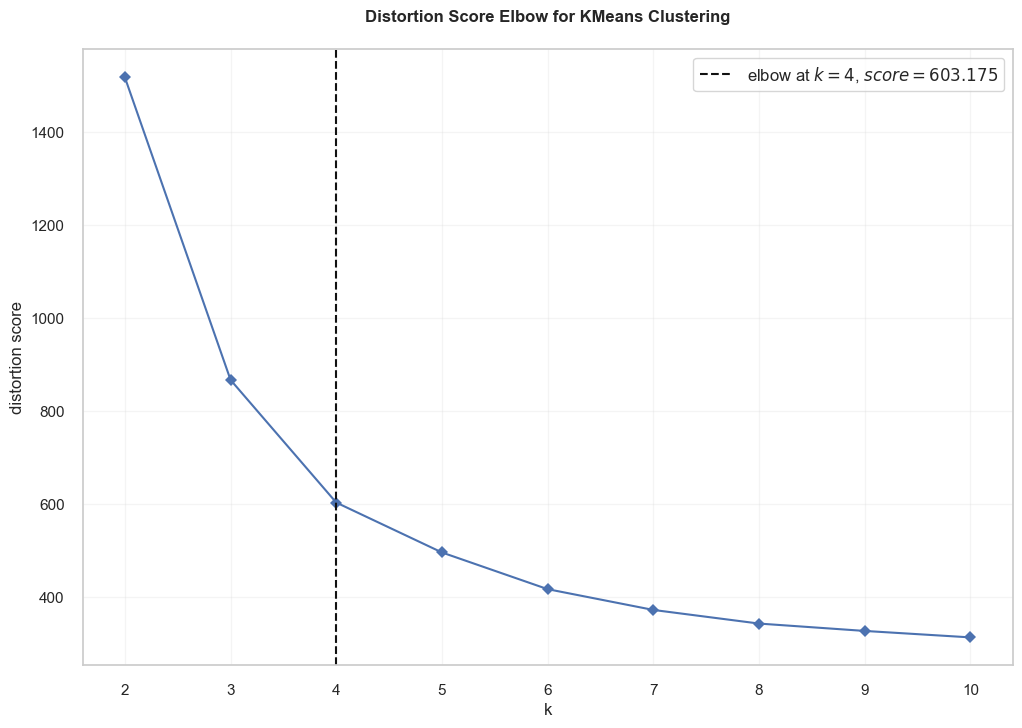

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [2859]:
kelbow_visualizer(KMeans(), X, k=10, timings=False)

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


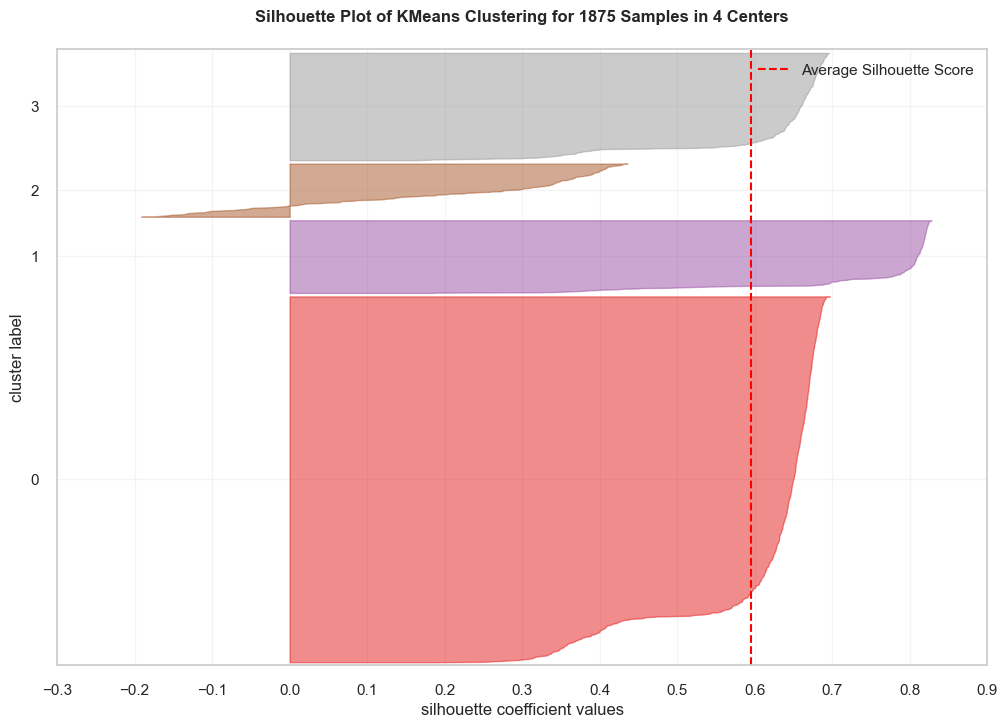

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1875 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4))

In [2860]:
# silhouette_visualizer
silhouette_visualizer(KMeans(n_clusters=4), X)

### model 1

In [2861]:
# Using KMeans
model = KMeans(n_clusters=4)
model.fit(model_1)

centroids = model.cluster_centers_
labels_1 = model.labels_
inertia = model.inertia_

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2862]:
# sklearn metrics
silhouette_score(model_1, labels)
davies_bouldin_score(model_1, labels)
calinski_harabasz_score(model_1, labels)

9231.578981777326

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

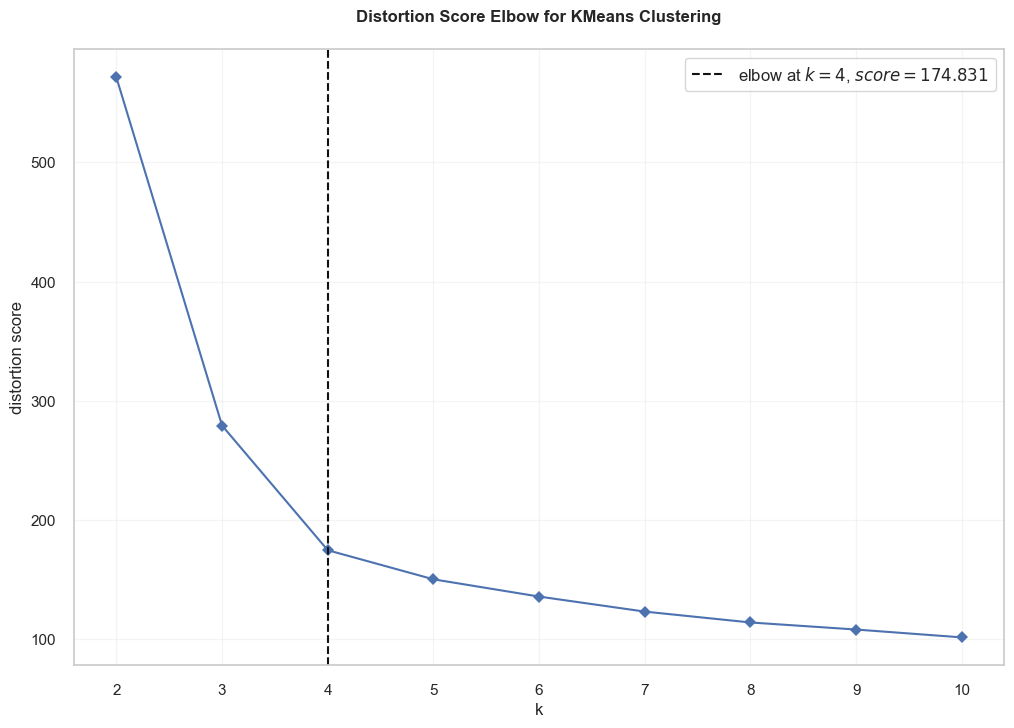

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [2863]:
kelbow_visualizer(KMeans(), model_1, k=10, timings=False)

### model 2

In [2864]:
# Using KMeans
model = KMeans(n_clusters=4)
model.fit(model_2)

centroids = model.cluster_centers_
labels_2 = model.labels_
inertia = model.inertia_

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2865]:
# sklearn metrics
silhouette_score(model_2, labels)
davies_bouldin_score(model_2, labels)
calinski_harabasz_score(model_2, labels)

6062.18597129101

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

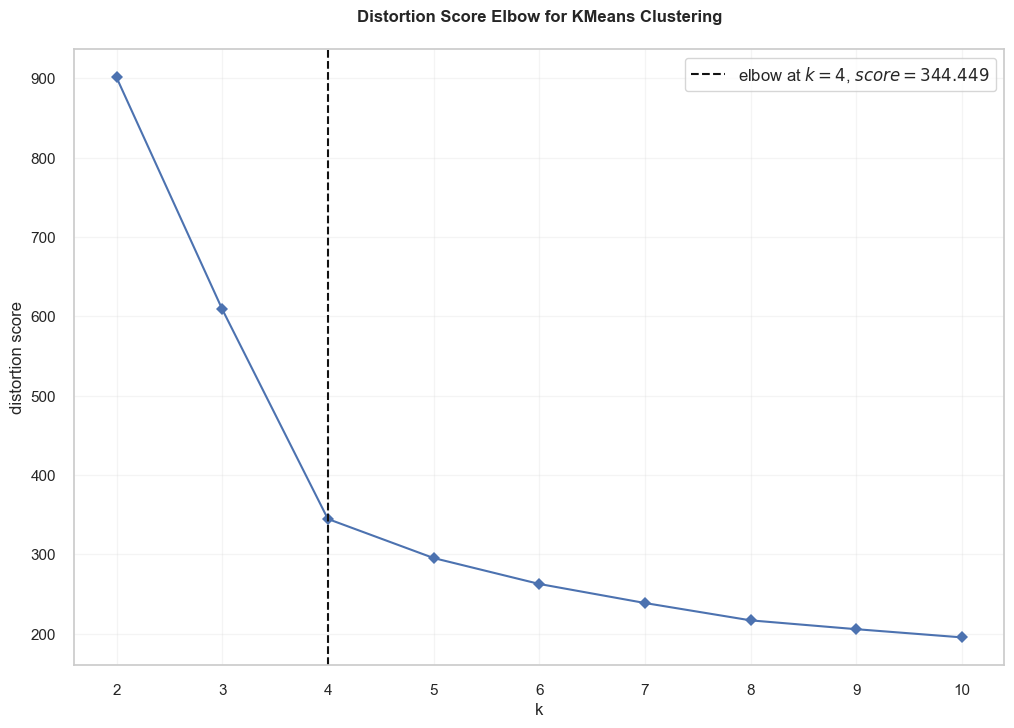

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [2866]:
kelbow_visualizer(KMeans(), model_2, k=10, timings=False)

### model 3

In [2867]:
# Using KMeans
model = KMeans(n_clusters=4)
model.fit(model_3)

centroids = model.cluster_centers_
labels_3 = model.labels_
inertia = model.inertia_

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2868]:
# sklearn metrics
silhouette_score(model_3, labels)
davies_bouldin_score(model_3, labels)
calinski_harabasz_score(model_3, labels)

12076.83972916187

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

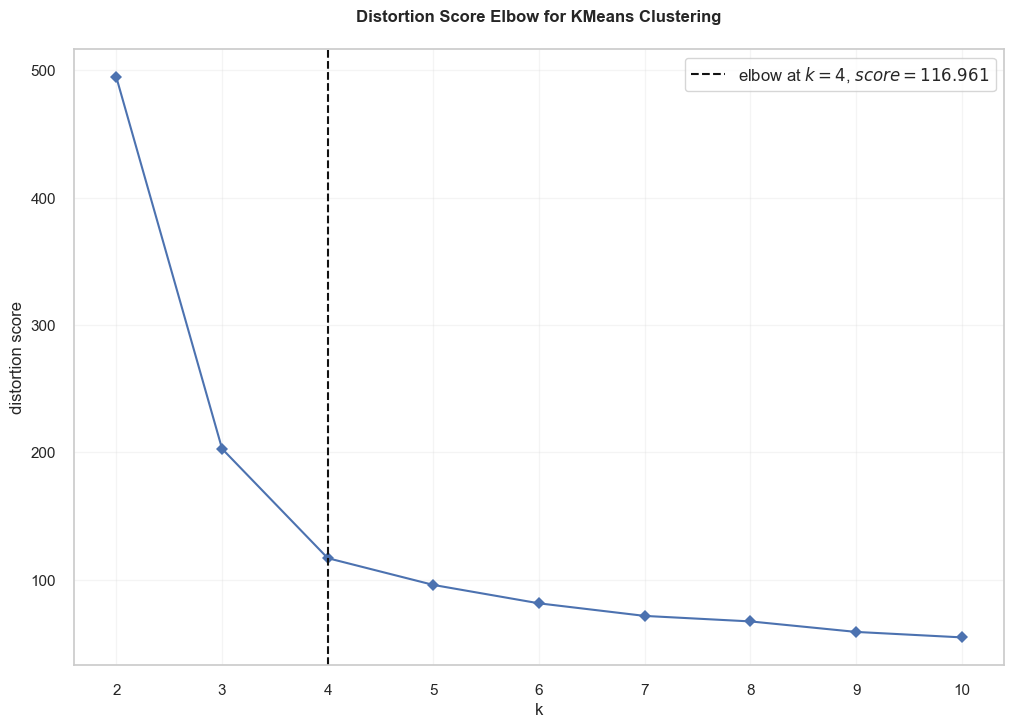

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [2869]:
kelbow_visualizer(KMeans(), model_3, k=10, timings=False)

### model 4

In [2870]:
# Using KMeans
model = KMeans(n_clusters=4)
model.fit(model_4)

centroids = model.cluster_centers_
labels_4 = model.labels_
inertia = model.inertia_

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2871]:
# sklearn metrics
silhouette_score(model_4, labels)
davies_bouldin_score(model_4, labels)
calinski_harabasz_score(model_4, labels)

9705.257346504157

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Sávio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

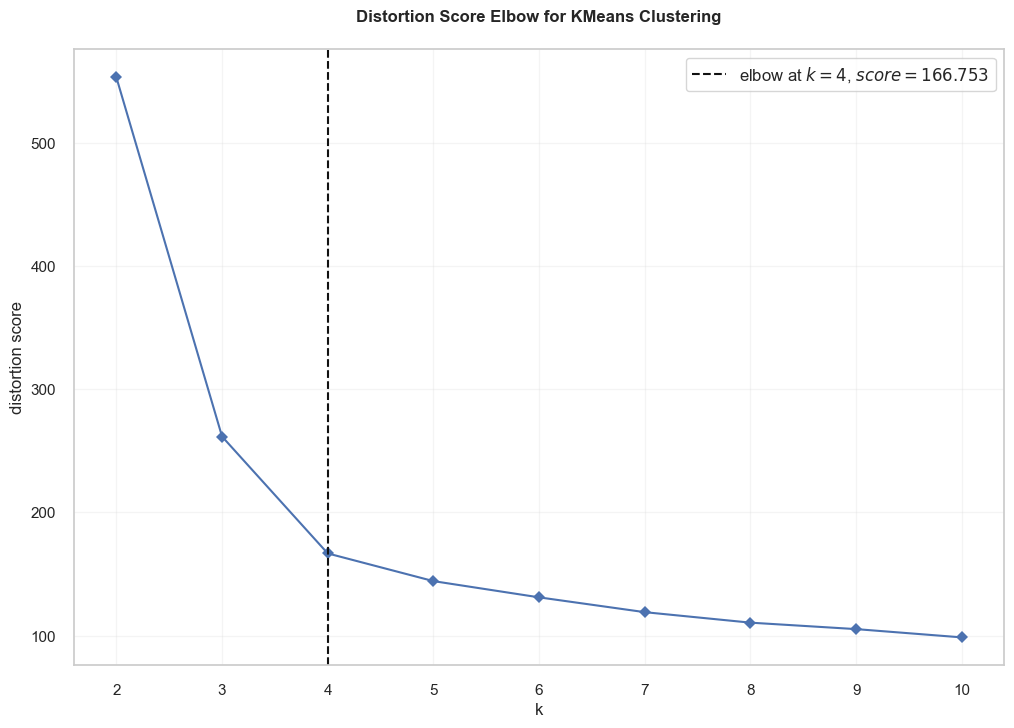

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [2872]:
kelbow_visualizer(KMeans(), model_4, k=10, timings=False)

## kprototypes

In [2873]:
# Define posições dos dados categóricos
categorical_columns = ['category_max']
categorical_idx = features_clientes.columns.isin(categorical_columns).nonzero()[0].tolist()

In [2874]:
# Modelagem com KPrototypes
model = KPrototypes(n_clusters=4)
model.fit(features_clientes, categorical=categorical_idx)

KPrototypes(gamma=0.05384554027545443, n_clusters=4)

In [2875]:
labels = model.predict(features_clientes, categorical=categorical_idx)

In [2876]:
# Avaliando modelo
custos = [
    KPrototypes(K).fit(features_clientes, categorical=categorical_idx).cost_
    for K in range(2,11)
    ]
custos

[525.2626887095674,
 391.8101775429298,
 342.74278716446634,
 317.01034724186707,
 298.46441538899677,
 292.4926640165131,
 273.80009537135646,
 274.4211649830581,
 257.8765214742336]

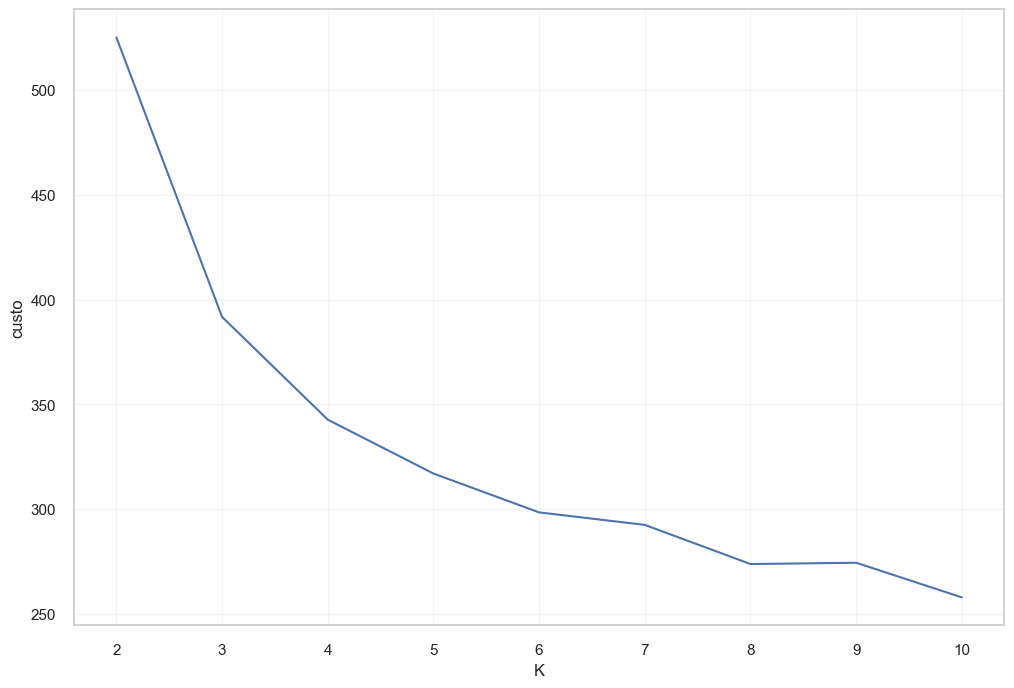

In [2877]:
pd.Series(custos, index=range(2,11)).plot()
plt.xlabel('K')
plt.ylabel('custo')
plt.show()

## model_1 

In [2878]:
# Modelagem com KPrototypes
model = KPrototypes(n_clusters=4)
model.fit(model_1, categorical=categorical_idx)

KPrototypes(gamma=0.04178679362796657, n_clusters=4)

In [2879]:
popo_1 = model.predict(model_1, categorical=categorical_idx)

In [2880]:
# Avaliando modelo
custos = [
    KPrototypes(K).fit(model_1, categorical=categorical_idx).cost_
    for K in range(2,11)
    ]
custos

[170.78041146166746,
 142.7442787685064,
 122.54186313909042,
 110.35176747042753,
 102.9274231511497,
 95.44457331695818,
 89.11985462889395,
 84.23335358631961,
 81.1085321591486]

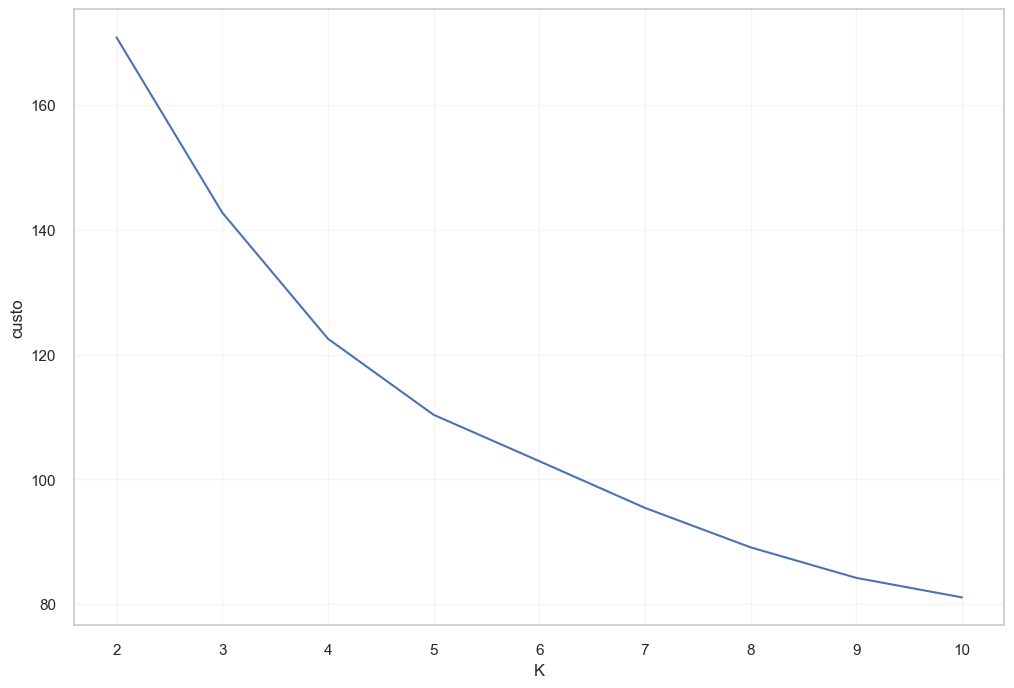

In [2881]:
pd.Series(custos, index=range(2,11)).plot()
plt.xlabel('K')
plt.ylabel('custo')
plt.show()

### model 2

In [2882]:
# Modelagem com KPrototypes
model = KPrototypes(n_clusters=4)
model.fit(model_2, categorical=categorical_idx)

KPrototypes(gamma=0.04930533335671738, n_clusters=4)

In [2883]:
popo_2 = model.predict(model_2, categorical=categorical_idx)

In [2884]:
# Avaliando modelo
custos = [
    KPrototypes(K).fit(model_2, categorical=categorical_idx).cost_
    for K in range(2,11)
    ]
custos

[314.88663630062825,
 251.6837326425924,
 225.5071653624509,
 208.46204997045223,
 193.3732235625456,
 180.93200202619255,
 173.24835892790833,
 160.38008262227135,
 160.07235235417343]

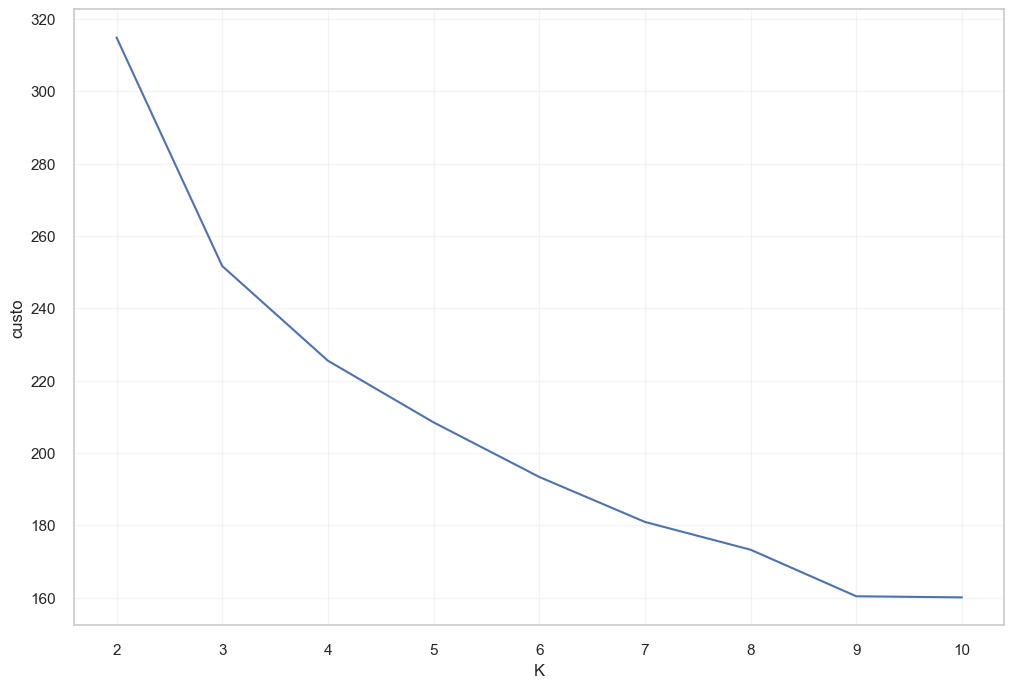

In [2885]:
pd.Series(custos, index=range(2,11)).plot()
plt.xlabel('K')
plt.ylabel('custo')
plt.show()

### model 3

In [2886]:
# Modelagem com KPrototypes
model = KPrototypes(n_clusters=4)
model.fit(model_3, categorical=categorical_idx)

KPrototypes(gamma=0.04644335934265484, n_clusters=4)

In [2887]:
popo_3 = model.predict(model_3, categorical=categorical_idx)

In [2888]:
# Avaliando modelo
custos = [
    KPrototypes(K).fit(model_3, categorical=categorical_idx).cost_
    for K in range(2,11)
    ]
custos

[119.5338574821744,
 94.02423748543767,
 75.87493731650969,
 62.54688148568296,
 54.3987772753493,
 49.162987293092044,
 45.24234793292587,
 42.157161407733696,
 39.855149188968696]

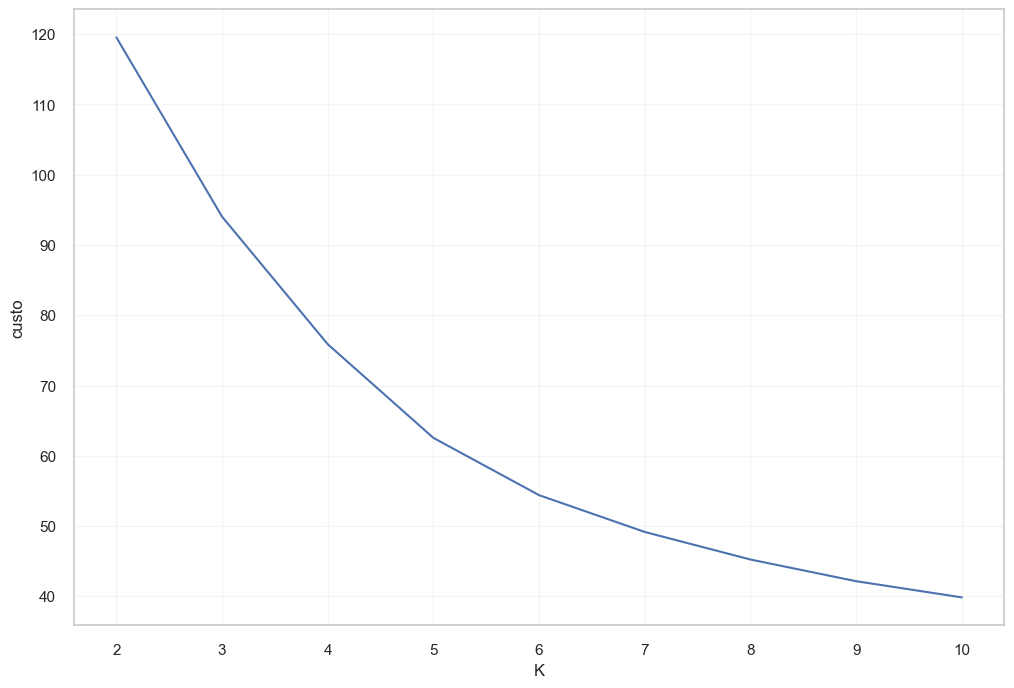

In [2889]:
pd.Series(custos, index=range(2,11)).plot()
plt.xlabel('K')
plt.ylabel('custo')
plt.show()

###  model 4

In [2890]:
# Modelagem com KPrototypes
model = KPrototypes(n_clusters=4)
model.fit(model_4, categorical=categorical_idx)

KPrototypes(gamma=0.04138017573174926, n_clusters=4)

In [2891]:
popo_4 = model.predict(model_4, categorical=categorical_idx)

In [2892]:
# Avaliando modelo
custos = [
    KPrototypes(K).fit(model_4, categorical=categorical_idx).cost_
    for K in range(2,11)
    ]
custos

[162.7865376697739,
 137.27372264149295,
 118.78698776485356,
 106.62356022347106,
 99.0930406189783,
 91.69167707239285,
 85.57388383511156,
 80.89985537255863,
 77.95025687669958]

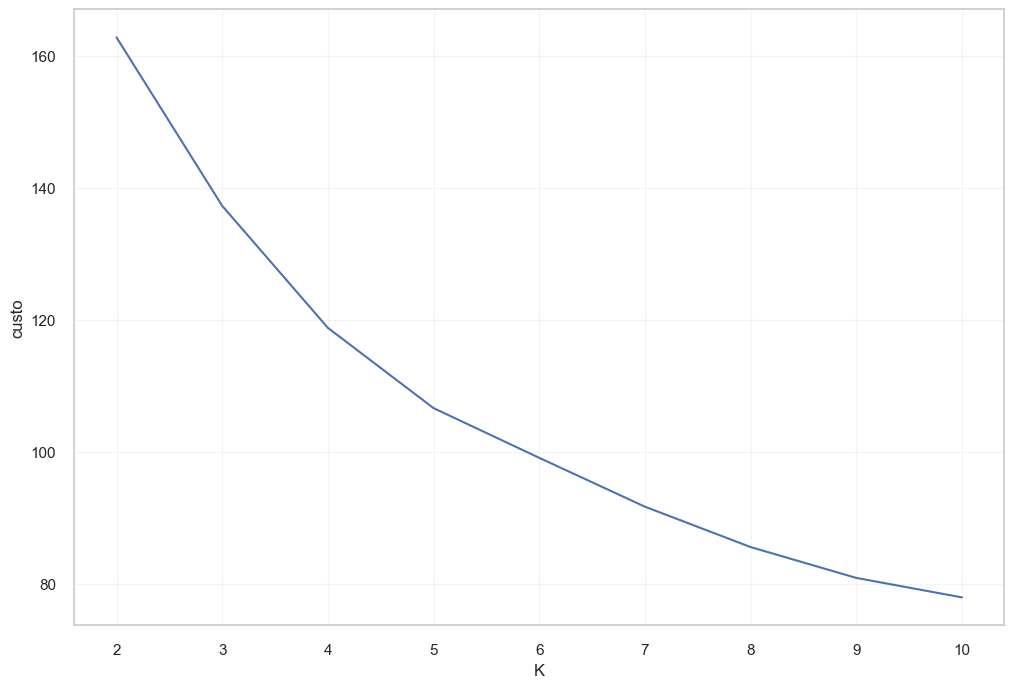

In [2893]:
pd.Series(custos, index=range(2,11)).plot()
plt.xlabel('K')
plt.ylabel('custo')
plt.show()

## Df para avaliação de cluster

In [2894]:
suitability = df.groupby('person_id')['suitability'].first().reset_index() #selecionando o suitability do cliente 
suitability.head()

,person_id,suitability
0,000be23a-894b-4eca-aa31-5373556f8204,moderado
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,agressivo


In [2895]:
idxmax_amount = df.groupby('person_id')['amount'].idxmin()

# Usando o índice para obter o 'subtype' correspondente
canal_compra = df.loc[idxmax_amount, ['person_id', 'subtype', 'amount']]
canal_compra = canal_compra.rename(columns={'amount': 'gastos_canal', 'subtype':'canal_compra'})

In [2896]:
gastos = df.groupby(['person_id','category'])['amount'].mean().reset_index() #media de gastos por categoria 
recebido_cliente = gastos[gastos['category'] == 'Recebido']                  #total recebido por cliente
recebido_cliente = recebido_cliente[['person_id','amount']]                    

investido_cliente = gastos[gastos['category'] == 'Investimento']             #total investido por cliente
investido_cliente = investido_cliente[['person_id','amount']]

In [2897]:
#total recebido por cliente
total_recebido = df.groupby(['person_id','category'])['amount'].sum().reset_index()
total_recebido = total_recebido[total_recebido['category'] == 'Recebido']
total_recebido = total_recebido[['person_id','amount']]  
total_recebido.head()

,person_id,amount
8,000be23a-894b-4eca-aa31-5373556f8204,107543.23
19,001de888-9b29-4b8e-95ca-59adc5903f45,55615.11
30,003d603d-a397-473e-a0d0-5c5a62faf0c5,70228.82
41,007acb4a-2a68-4437-85e2-0bbda827360c,21697.23
50,0084deeb-c9c8-4006-b6f0-8efb8a57533e,12889.15


In [2898]:
#renomeando colunas
recebido_cliente = recebido_cliente.rename(columns={'amount': 'recebimento_medio'})
investido_cliente = investido_cliente.rename(columns={'amount': 'total_investido'})
total_recebido = total_recebido.rename(columns={'amount': 'total_gasto'})

In [2899]:
canal_compra['suitability'] = suitability['suitability'] #migrando informações

In [2900]:
df_evaluation = pd.merge(suitability, 
                         canal_compra, 
                         on='person_id', 
                         how='inner')    #mesclando dfs

In [2901]:
df_evaluation = pd.merge(df_evaluation, 
                         recebido_cliente, 
                         on='person_id', 
                         how='inner') #mesclando dfs

In [2902]:
df_evaluation = pd.merge(df_evaluation, 
                         investido_cliente, 
                         on='person_id', 
                         how='inner') #mesclando dfs

In [2903]:
df_evaluation = pd.merge(df_evaluation, 
                         total_recebido, 
                         on='person_id', 
                         how='inner') #mesclando dfs

In [2904]:
df_evaluation.drop(columns='suitability_y', inplace=True) 

In [2905]:
df_evaluation = df_evaluation.rename(columns={'suitability_x': 'suitability'})
df_evaluation.head() 

,person_id,suitability,canal_compra,gastos_canal,recebimento_medio,total_investido,total_gasto
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,SAVINGS_ACCOUNT,-6560.55,4301.729200,1030.345455,107543.23
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,SAVINGS_ACCOUNT,-3278.53,2224.604400,764.457500,55615.11
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,CREDIT_CARD,-21229.97,14045.764000,4761.868235,70228.82
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,CREDIT_CARD,-2924.11,2410.803333,523.850000,21697.23
4,0098357f-73ce-4d05-ba22-ff5a395676ed,agressivo,CHECKING_ACCOUNT,-4745.49,4519.518571,356.873333,31636.63


In [2906]:
df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person_id          2001 non-null   object 
 1   suitability        2001 non-null   object 
 2   canal_compra       2001 non-null   object 
 3   gastos_canal       2001 non-null   float64
 4   recebimento_medio  2001 non-null   float64
 5   total_investido    2001 non-null   float64
 6   total_gasto        2001 non-null   float64
dtypes: float64(4), object(3)
memory usage: 109.6+ KB


In [2907]:
features_clientes.head()

,category_max,total_spent,total_Educação,25_Educação,50_Educação,75_Educação,total_Outras saídas,25_Outras saídas,50_Outras saídas,75_Outras saídas,...,50_Lazer,75_Lazer,fixed_expense_meany,fixed_expense_maxy,fixed_expense_miny,fixed_expense_mediany,fixed_expense_max_variable,fixed_expense_median_variable,fixed_expense_min_variable,fixed_expense_mean_variable
0,0,0.737002,0.909049,0.843778,0.832388,0.889644,0.840637,0.713502,0.847035,0.941509,...,0.815047,0.908919,0.467520,0.132869,0.599725,0.354644,0.961672,0.888263,0.599725,0.696000
1,0,0.883826,0.924864,0.880744,0.917762,0.968450,0.866657,0.871831,0.876328,0.947068,...,0.911261,0.966096,0.430984,0.055649,0.936315,0.298708,0.981228,0.929393,0.936315,0.921765
2,0,0.455451,0.687278,0.172568,0.393659,0.507510,0.766310,0.316415,0.434556,0.555250,...,0.376264,0.431802,0.000000,0.072882,0.000000,0.155662,0.975543,0.503835,0.000000,0.000000
3,0,0.970627,0.986969,0.878657,0.930973,0.933484,0.971757,0.938604,0.940235,0.937519,...,0.923861,0.928543,0.480434,0.085782,0.981863,0.306567,0.945535,0.892759,0.981863,0.941338
4,0,0.929399,0.963336,0.876920,0.880581,0.906026,0.893736,0.799213,0.743152,0.967395,...,0.677999,0.755728,0.435442,0.126420,0.894074,0.291971,0.954604,0.922195,0.894074,0.868285


In [2908]:
clientes.dropna(inplace=True)

In [2909]:
df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person_id          2001 non-null   object 
 1   suitability        2001 non-null   object 
 2   canal_compra       2001 non-null   object 
 3   gastos_canal       2001 non-null   float64
 4   recebimento_medio  2001 non-null   float64
 5   total_investido    2001 non-null   float64
 6   total_gasto        2001 non-null   float64
dtypes: float64(4), object(3)
memory usage: 109.6+ KB


## evaluation

In [2910]:
resultados_clientes.head()

,person_id,category_max,total_spent,total_Educação,25_Educação,50_Educação,75_Educação,total_Outras saídas,25_Outras saídas,50_Outras saídas,...,50_Lazer,75_Lazer,fixed_expense_meany,fixed_expense_maxy,fixed_expense_miny,fixed_expense_mediany,fixed_expense_max_variable,fixed_expense_median_variable,fixed_expense_min_variable,fixed_expense_mean_variable
0,000be23a-894b-4eca-aa31-5373556f8204,Compras,-84880.85,-25568.23,-2008.620,-1837.390,-1163.8800,-26194.79,-3174.8475,-1250.030,...,-582.990,-267.130,728.191818,9993.20,-22147.80,578.470,-207.77,-913.005,-22147.80,-3755.306000
1,001de888-9b29-4b8e-95ca-59adc5903f45,Compras,-38596.47,-21176.45,-1604.365,-1038.085,-501.3075,-21929.10,-1442.7400,-1018.415,...,-292.070,-113.935,-211.232083,3307.60,-3543.75,-488.185,-106.98,-585.670,-3543.75,-984.074211
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,Compras,-173636.11,-87152.15,-9348.800,-5944.970,-4376.6900,-38379.81,-7518.9450,-4511.370,...,-1909.735,-1545.470,-11292.828824,4799.64,-55295.84,-3215.950,-136.28,-3972.445,-55295.84,-12298.608125
3,007acb4a-2a68-4437-85e2-0bbda827360c,Compras,-11233.45,-3930.56,-1627.190,-914.400,-795.2900,-4699.14,-712.2500,-513.120,...,-253.970,-214.550,1060.236000,5916.52,-1026.24,-338.330,-290.94,-877.220,-1026.24,-743.813333
4,0098357f-73ce-4d05-ba22-ff5a395676ed,Compras,-24230.30,-10493.22,-1646.185,-1386.190,-1026.1450,-17489.81,-2237.1775,-2071.395,...,-997.380,-677.575,-96.595556,9434.86,-5878.50,-616.660,-244.20,-642.960,-5878.50,-1640.532000


In [2911]:
resultados_clientes.dropna(inplace=True)

In [2912]:
resultados_clientes['f_clientes'] = labels
resultados_clientes['labels_1'] = labels_1
resultados_clientes['labels_2'] = labels_2
resultados_clientes['labels_3'] = labels_3
resultados_clientes['labels_4'] = labels_4

In [2913]:
resultados_clientes['popo_1'] = popo_1
resultados_clientes['popo_2'] = popo_2
resultados_clientes['popo_3'] = popo_3
resultados_clientes['popo_4'] = popo_4

In [2914]:
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'popo_1']],
                                   on='person_id',
                                   how='inner')
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'popo_2']],
                                   on='person_id',
                                   how='inner')
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'popo_3']],
                                   on='person_id',
                                   how='inner')
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'popo_4']],
                                   on='person_id',
                                   how='inner')
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'category_max']],
                                   on='person_id',
                                   how='inner')

df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'fixed_expense_meany', 'fixed_expense_maxy',
                                                         'fixed_expense_miny','fixed_expense_mediany','fixed_expense_max_variable',
                                                         'fixed_expense_median_variable','fixed_expense_min_variable','fixed_expense_mean_variable']],
                                                                                                                                                    on='person_id',
                                                                                                                                                    how='inner')


In [2915]:
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'labels_1']],
                                   on='person_id',
                                   how='inner')


In [2916]:
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'labels_2']],
                                   on='person_id',
                                   how='inner')

In [2917]:
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'labels_3']],
                                   on='person_id',
                                   how='inner')

In [2918]:
df_evaluation = df_evaluation.merge(resultados_clientes[['person_id', 'labels_4']],
                                   on='person_id',
                                   how='inner')

In [2919]:
resultados_clientes['f_clientes'].value_counts()

f_clientes
0    1494
2     246
1     110
3      25
Name: count, dtype: int64

In [2920]:
resultados_clientes['labels_1'].value_counts()

labels_1
1    1182
2     363
0     228
3     102
Name: count, dtype: int64

In [2921]:
resultados_clientes['labels_2'].value_counts()

labels_2
0    1162
2     346
1     228
3     139
Name: count, dtype: int64

In [2922]:
resultados_clientes['labels_3'].value_counts()

labels_3
0    1176
2     363
1     228
3     108
Name: count, dtype: int64

In [2923]:
resultados_clientes['labels_4'].value_counts()

labels_4
0    1177
2     364
1     228
3     106
Name: count, dtype: int64

In [2924]:
df_evaluation.head()

,person_id,suitability,canal_compra,gastos_canal,recebimento_medio,total_investido,total_gasto,popo_1,popo_2,popo_3,...,fixed_expense_miny,fixed_expense_mediany,fixed_expense_max_variable,fixed_expense_median_variable,fixed_expense_min_variable,fixed_expense_mean_variable,labels_1,labels_2,labels_3,labels_4
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,SAVINGS_ACCOUNT,-6560.55,4301.729200,1030.345455,107543.23,2,2,0,...,-22147.80,578.470,-207.77,-913.005,-22147.80,-3755.306000,1,0,0,0
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,SAVINGS_ACCOUNT,-3278.53,2224.604400,764.457500,55615.11,0,0,0,...,-3543.75,-488.185,-106.98,-585.670,-3543.75,-984.074211,1,0,0,0
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,CREDIT_CARD,-21229.97,14045.764000,4761.868235,70228.82,3,3,3,...,-55295.84,-3215.950,-136.28,-3972.445,-55295.84,-12298.608125,3,3,3,3
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,CREDIT_CARD,-2924.11,2410.803333,523.850000,21697.23,1,0,2,...,-1026.24,-338.330,-290.94,-877.220,-1026.24,-743.813333,1,0,0,0
4,0098357f-73ce-4d05-ba22-ff5a395676ed,agressivo,CHECKING_ACCOUNT,-4745.49,4519.518571,356.873333,31636.63,1,2,2,...,-5878.50,-616.660,-244.20,-642.960,-5878.50,-1640.532000,1,0,0,0


In [2925]:
df_evaluation.columns

Index(['person_id', 'suitability', 'canal_compra', 'gastos_canal',
       'recebimento_medio', 'total_investido', 'total_gasto', 'popo_1',
       'popo_2', 'popo_3', 'popo_4', 'fixed_expense_meany',
       'fixed_expense_maxy', 'fixed_expense_miny', 'fixed_expense_mediany',
       'fixed_expense_max_variable', 'fixed_expense_median_variable',
       'fixed_expense_min_variable', 'fixed_expense_mean_variable', 'labels_1',
       'labels_2', 'labels_3', 'labels_4'],
      dtype='object')

In [2926]:
# Suponha que você deseja renomear as colunas 'coluna_antiga' para 'nova_coluna' e 'outra_coluna_antiga' para 'outra_nova_coluna'

novo_nome_das_colunas = {
    'fixed_expense_meany': 'despesa_fixa_media',
    'fixed_expense_maxy': 'despesa_fixa_min',
    'fixed_expense_miny':'despesa_fixa_max',
    'fixed_expense_mediany':'despesa_fixa_median',
    'fixed_expense_max_variable':'despesa_variavel_min',
    'fixed_expense_median_variable':'despesa_variavel_max',
    'fixed_expense_min_variable':'despesa_variavel_max',
    'fixed_expense_mean_variable':'despesa_variavel_media'
}

df_evaluation.rename(columns=novo_nome_das_colunas, inplace=True)


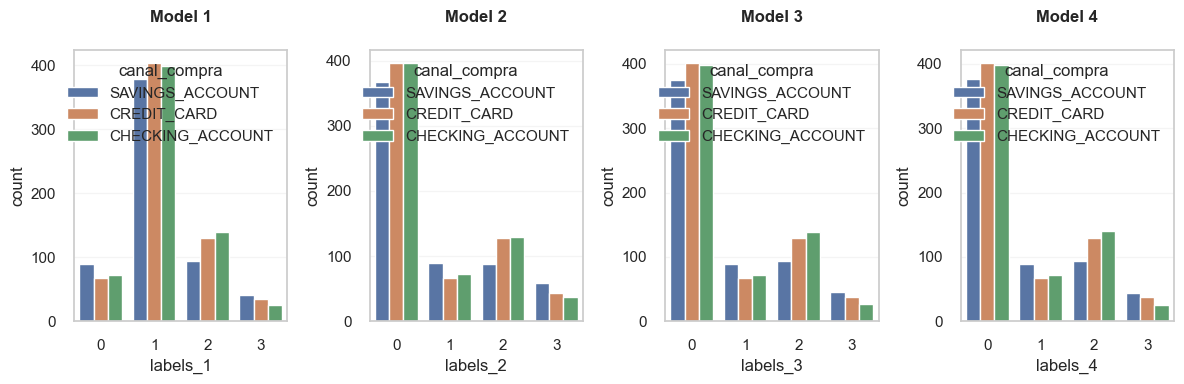

In [2927]:
# gráfico com quatro subplots em uma linha
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# CountPlot no primeiro subplot
sns.countplot(data=df_evaluation, x='labels_1', hue='canal_compra', ax=axes[0])
axes[0].set_title('Model 1')

#  CountPlot no segundo subplot
sns.countplot(data=df_evaluation, x='labels_2',  hue='canal_compra',ax=axes[1])
axes[1].set_title('Model 2')

#  CountPlot no terceiro subplot
sns.countplot(data=df_evaluation, x='labels_3', hue='canal_compra', ax=axes[2])
axes[2].set_title('Model 3')

#  CountPlot no quarto subplot
sns.countplot(data=df_evaluation, x='labels_4', hue='canal_compra', ax=axes[3])
axes[3].set_title('Model 4')

# Ajuste o layout 
plt.tight_layout()

plt.show()

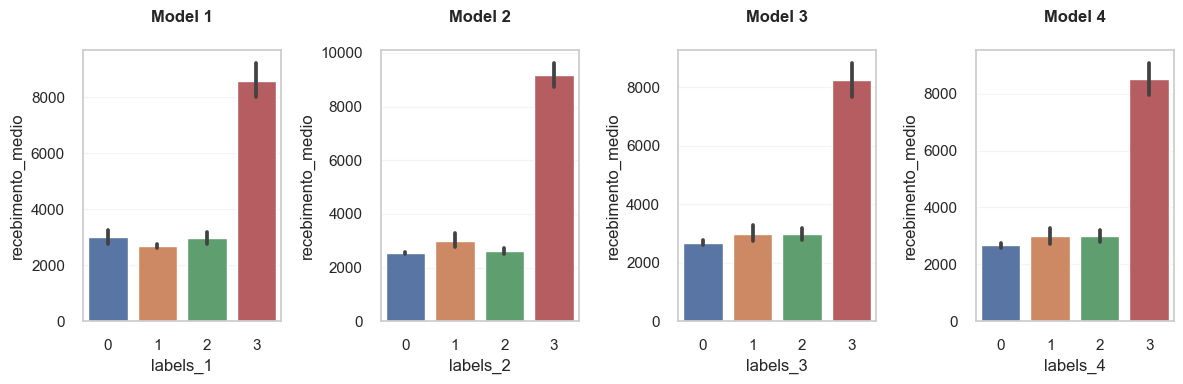

In [2928]:
#  quatro subplots em uma linha
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

#  primeiro subplot
sns.barplot(data=df_evaluation, x='labels_1', y='recebimento_medio', ax=axes[0])
axes[0].set_title('Model 1')

# segundo subplot
sns.barplot(data=df_evaluation, x='labels_2',  y='recebimento_medio',ax=axes[1])
axes[1].set_title('Model 2')

# terceiro subplot
sns.barplot(data=df_evaluation, x='labels_3', y='recebimento_medio', ax=axes[2])
axes[2].set_title('Model 3')

# quarto subplot
sns.barplot(data=df_evaluation, x='labels_4', y='recebimento_medio', ax=axes[3])
axes[3].set_title('Model 4')

#  layout dos subplots
plt.tight_layout()

plt.show()

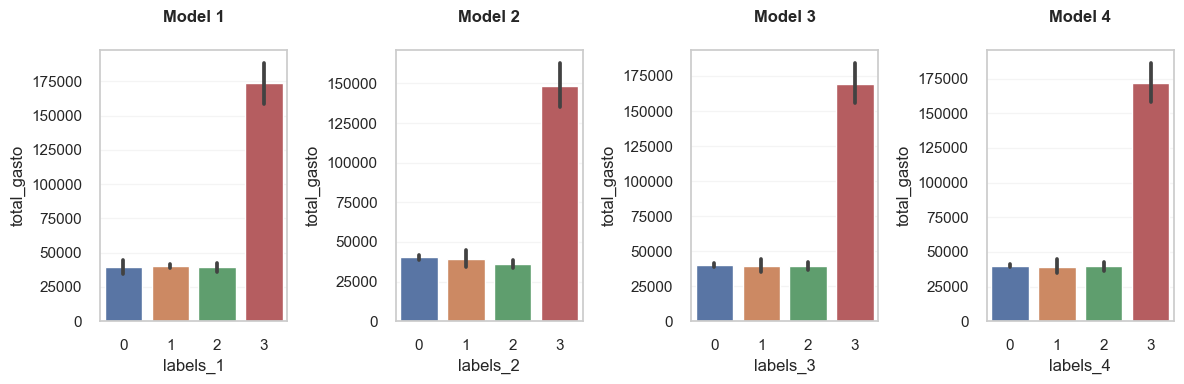

In [2929]:
# subplots em uma linha
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

#  primeiro subplot
sns.barplot(data=df_evaluation, x='labels_1', y='total_gasto', ax=axes[0])
axes[0].set_title('Model 1')

#  segundo subplot
sns.barplot(data=df_evaluation, x='labels_2',  y='total_gasto',ax=axes[1])
axes[1].set_title('Model 2')

#  terceiro subplot
sns.barplot(data=df_evaluation, x='labels_3', y='total_gasto', ax=axes[2])
axes[2].set_title('Model 3')

#  quarto subplot
sns.barplot(data=df_evaluation, x='labels_4', y='total_gasto', ax=axes[3])
axes[3].set_title('Model 4')

# layout dos subplots
plt.tight_layout()

plt.show()

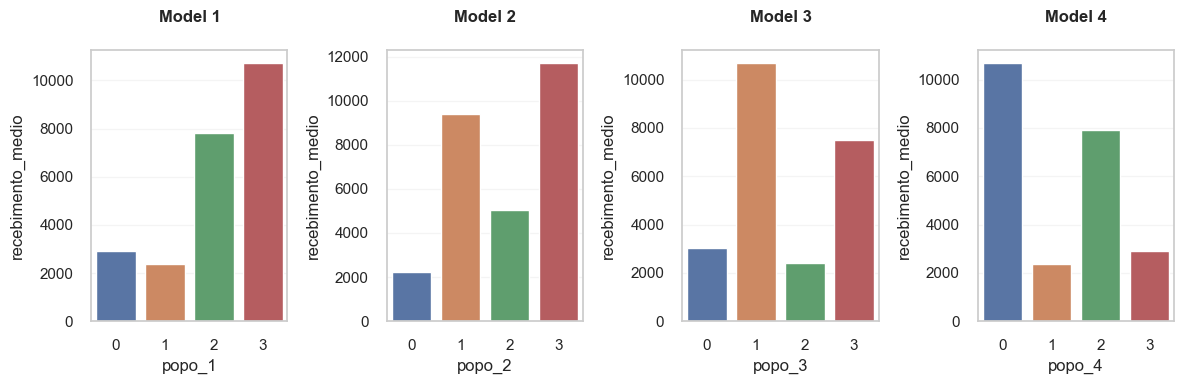

In [2958]:
#subplots em uma linha
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# primeiro subplot
sns.barplot(data=df_evaluation, x='popo_1', y='recebimento_medio', errorbar=None, ax=axes[0])
axes[0].set_title('Model 1')

# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2',  y='recebimento_medio', errorbar=None, ax=axes[1])
axes[1].set_title('Model 2')

# terceiro subplot
sns.barplot(data=df_evaluation, x='popo_3', y='recebimento_medio', errorbar=None, ax=axes[2])
axes[2].set_title('Model 3')

# quarto subplot
sns.barplot(data=df_evaluation, x='popo_4', y='recebimento_medio', errorbar=None, ax=axes[3])
axes[3].set_title('Model 4')

# layout dos subplots
plt.tight_layout()

plt.show()

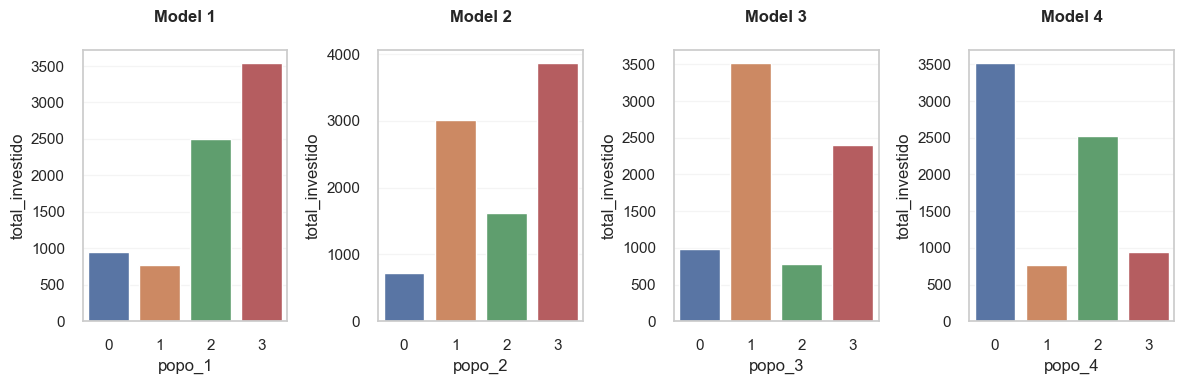

In [2957]:
# subplots em uma linha
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# primeiro subplot
sns.barplot(data=df_evaluation, x='popo_1', y='total_investido',errorbar=None, ax=axes[0])
axes[0].set_title('Model 1')

# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2',  y='total_investido',errorbar=None, ax=axes[1])
axes[1].set_title('Model 2')

# terceiro subplot
sns.barplot(data=df_evaluation, x='popo_3', y='total_investido',errorbar=None, ax=axes[2])
axes[2].set_title('Model 3')

# quarto subplot
sns.barplot(data=df_evaluation, x='popo_4', y='total_investido', errorbar=None, ax=axes[3])
axes[3].set_title('Model 4')

# layout dos subplots
plt.tight_layout()

plt.show()

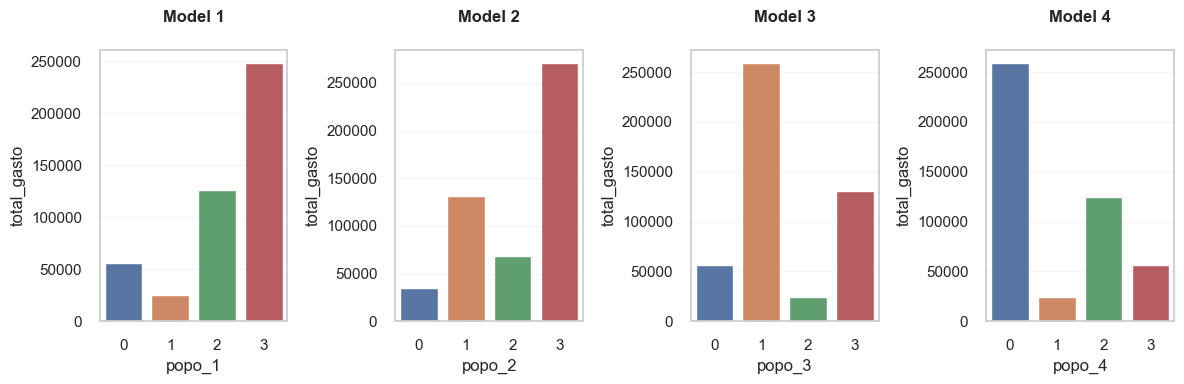

In [2956]:
# subplots em uma linha
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

# primeiro subplot
sns.barplot(data=df_evaluation, x='popo_1', y='total_gasto',errorbar=None, ax=axes[0])
axes[0].set_title('Model 1')

# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2',  y='total_gasto',errorbar=None,ax=axes[1])
axes[1].set_title('Model 2')

# terceiro subplot
sns.barplot(data=df_evaluation, x='popo_3', y='total_gasto', errorbar=None,ax=axes[2])
axes[2].set_title('Model 3')

# quarto subplot
sns.barplot(data=df_evaluation, x='popo_4', y='total_gasto',errorbar=None, ax=axes[3])
axes[3].set_title('Model 4')

# Ajuste o layout dos subplots
plt.tight_layout()

# Exiba o gráfico
plt.show()

## Modelo escolhido

A partir da observação dos agrupamentos, optou-se por explorar o modelo de cluster gerado pelo algoritmo Kprototypes e intitulado de 'model_2': 'popo_2'.

### Especificações

- 4 grupos com recebimentos bem distribuidos (com recebimentos até 2, 5, 9 e 11 mil, respectivamente)
- os investimentos seguem a mesma linha em cada grupo
- os gastos idem, podendo variar em até 40, 60, 140 e 260 mil em cada grupo

### Análise seguinte

A partir dessas informações, vamos explorar melhor o modelo 2, afim de obter informações sobre gastos fixos e variáveis e categoria de compra mais consumida em cada grupo.

In [2936]:
df_evaluation.head()

,person_id,suitability,canal_compra,gastos_canal,recebimento_medio,total_investido,total_gasto,popo_1,popo_2,popo_3,...,despesa_fixa_max,despesa_fixa_median,despesa_variavel_min,despesa_variavel_max,despesa_variavel_max,despesa_variavel_media,labels_1,labels_2,labels_3,labels_4
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,SAVINGS_ACCOUNT,-6560.55,4301.729200,1030.345455,107543.23,2,2,0,...,-22147.80,578.470,-207.77,-913.005,-22147.80,-3755.306000,1,0,0,0
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,SAVINGS_ACCOUNT,-3278.53,2224.604400,764.457500,55615.11,0,0,0,...,-3543.75,-488.185,-106.98,-585.670,-3543.75,-984.074211,1,0,0,0
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,CREDIT_CARD,-21229.97,14045.764000,4761.868235,70228.82,3,3,3,...,-55295.84,-3215.950,-136.28,-3972.445,-55295.84,-12298.608125,3,3,3,3
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,CREDIT_CARD,-2924.11,2410.803333,523.850000,21697.23,1,0,2,...,-1026.24,-338.330,-290.94,-877.220,-1026.24,-743.813333,1,0,0,0
4,0098357f-73ce-4d05-ba22-ff5a395676ed,agressivo,CHECKING_ACCOUNT,-4745.49,4519.518571,356.873333,31636.63,1,2,2,...,-5878.50,-616.660,-244.20,-642.960,-5878.50,-1640.532000,1,0,0,0


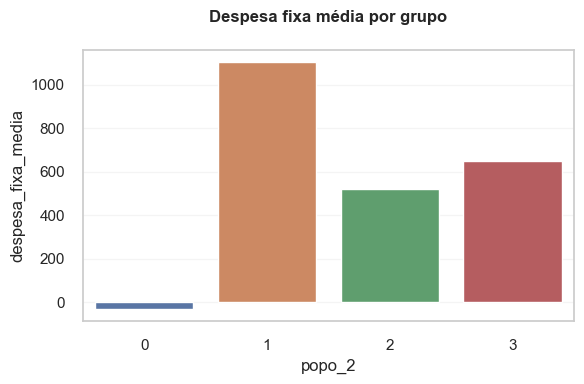

In [2960]:
plt.figure(figsize=(6,4))
# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2',  y='despesa_fixa_media', errorbar=None)
plt.title('Despesa fixa média por grupo')

# Ajuste o layout dos subplots
plt.tight_layout()

# Exiba o gráfico
plt.show()

Podemos observar uma variedade de comportamento entre os grupos, sendo o grupo 1 o que mais gasta com despesa fixa e o grupo 0 o que menos gasta e isso é um bom insight para saber onde atacar esses grupos futuramente.

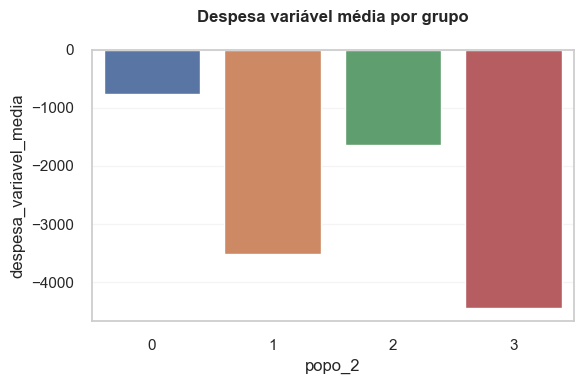

In [2963]:
plt.figure(figsize=(6,4))
# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2',  y='despesa_variavel_media',errorbar=None)
plt.title('Despesa variável média por grupo')

# Ajuste o layout dos subplots
plt.tight_layout()

# Exiba o gráfico
plt.show()

Sobre as despesas variáveis, dois grupos obtem destaque (1 e 3)

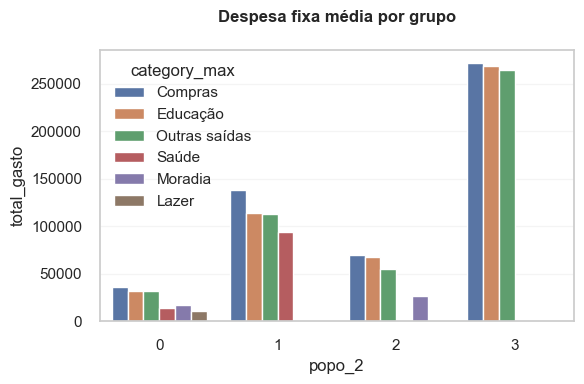

In [2962]:
plt.figure(figsize=(6,4))
# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2', y='total_gasto', hue='category_max', errorbar=None)
plt.title('Despesa fixa média por grupo')

# Ajuste o layout dos subplots
plt.tight_layout()

# Exiba o gráfico
plt.show()

Sobre as categorias que mais impactam, acima podemos ver as que categorias em que os clientes mais gastaram em cada grupo.

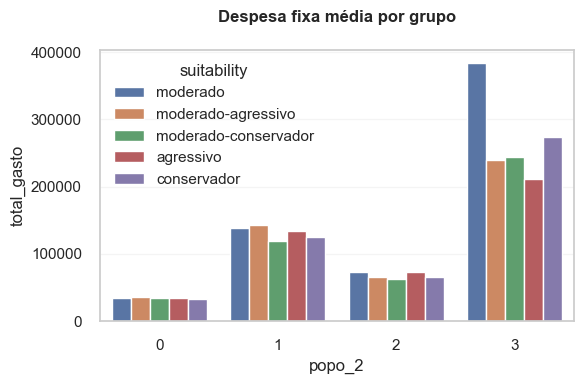

In [2964]:
plt.figure(figsize=(6,4))
# segundo subplot
sns.barplot(data=df_evaluation, x='popo_2', y='total_gasto', hue='suitability', errorbar=None)
plt.title('Despesa fixa média por grupo')

# Ajuste o layout dos subplots
plt.tight_layout()

# Exiba o gráfico
plt.show()

Sobre o perfil de investimento, o que conseguimos obter foi que o grupo 3 tem um volume maior de investidores conservadores, esse conservadorismo pode ser gerado, também por um alto indice de gastos variáveis, falta de conhecimento de mercado e receio de perder o investimento.

Futuramente esse dado pode ser investigado junto à o tipo de pagamento utilizado pelo cliente para tentarmos linkar as informações